# CANDOGLIA RIVER BASIN

13/10/2021

In this notebook results of different feature selections are compared for the Candoglia basin (of which we have around 18 years of data)

Input data is clipped from ERA5 metereological reanalysis quantile mapped and downscaled.

Monthly averages (for the previous year) of pecipitation, temperature and potential evapotranspiration are selected as input.


The settings are the following:

    A) 180 features are selected with PCA, the same numeriosity as setting C) ;

    B) 36 features are selectedwith PCA, the same numeriosity as setting D) ;
        
    C) metereological inputs spatial statistics are used as input: mean, the 5th, 25th, 75th and 95th quantiles are selected.
        
    D) metereological inputs are spatially averaged.




import sys
sys.path.append('/time_unit')

In [72]:
from sf_runoff_lt import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies


from nested_CV_lt import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test_lt import evaluate_prediction, plot_prediction, plot_anomalies
from test_lt import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
#from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

import os

import pdb
import seaborn as sns

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'CANDOGLIA_TOCE_2000_2019.csv', index_col=0, parse_dates=True)

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

In [71]:
import sys, importlib
importlib.reload(sys.modules['nested_CV_lt'])


<module 'nested_CV_lt' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\nested_CV_lt.py'>

In [61]:
t_unit=30
lt=1


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-4, 2, 10)
epsilon_range=np.logspace(-4, 0, 5)
#n_range = [17, 50, 200]
components_range = [5*3*12]
#do not enlarge t_range for now
t_range=[12]
n_splits=4
test_size=365

In [62]:
from sf_runoff import create_it_matrix
from sf_runoff_lt import create_it_matrix_lt

In [63]:
t_length=t_range[0]
it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

In [64]:
it_matrix_lt=create_it_matrix_lt(daily_input,t_length,t_unit,lt).astype('float32')

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C=0.01
eps=0.1
n=180


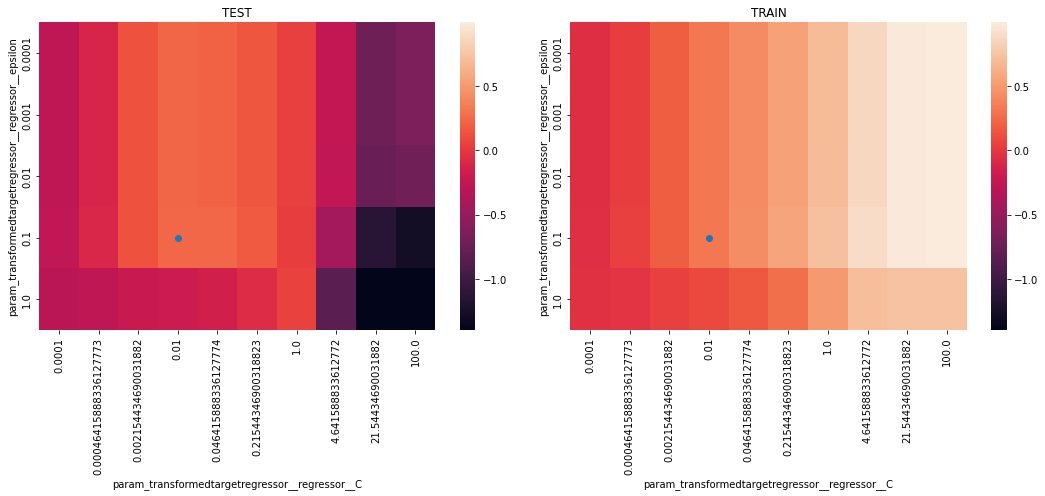

In [65]:
C,eps,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C={C}')
print(f'eps={eps}')
print(f'n={n}')

In [5]:
C=0.21544346900318834
eps=0.01
n=180

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [17]:
radius_for_ensemble = 1
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps, n, 12, t_unit, n_splits, test_size, radius_for_ensemble,lt)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

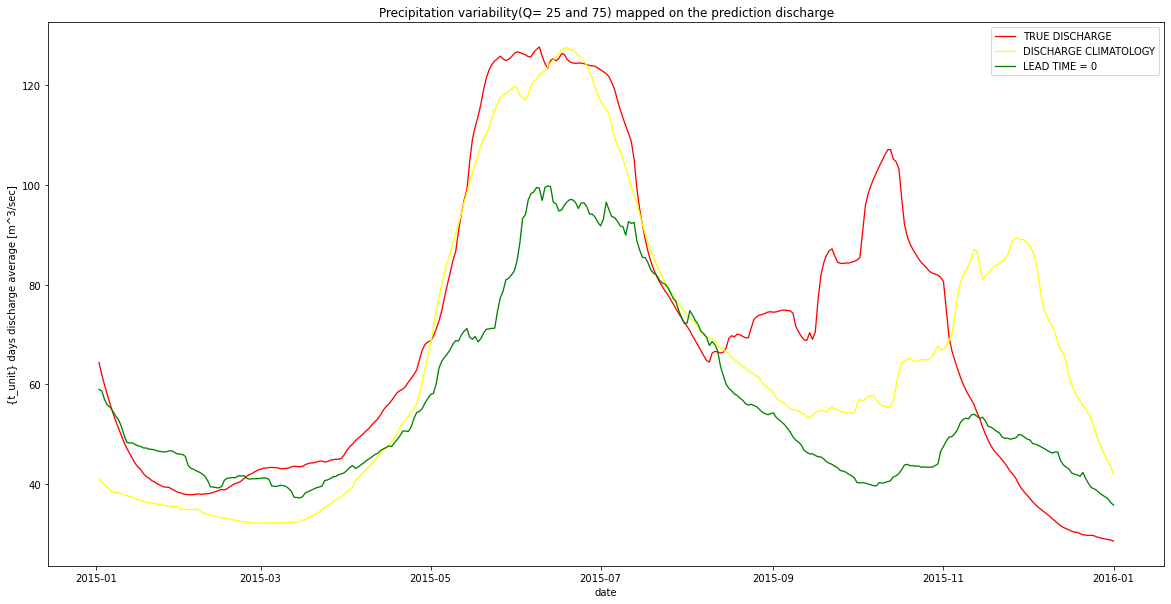

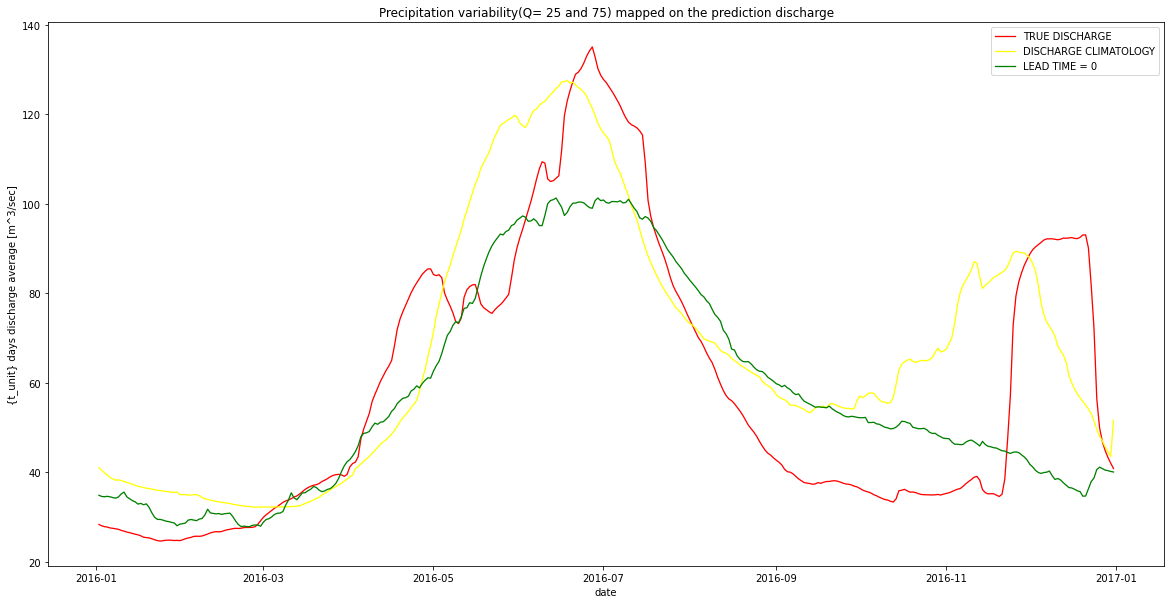

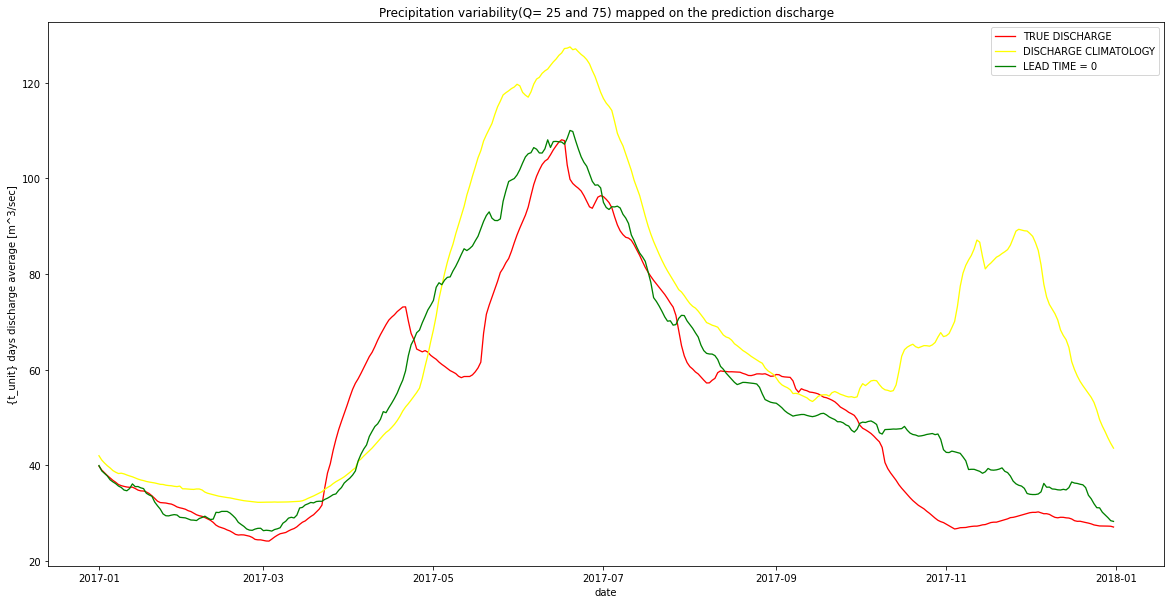

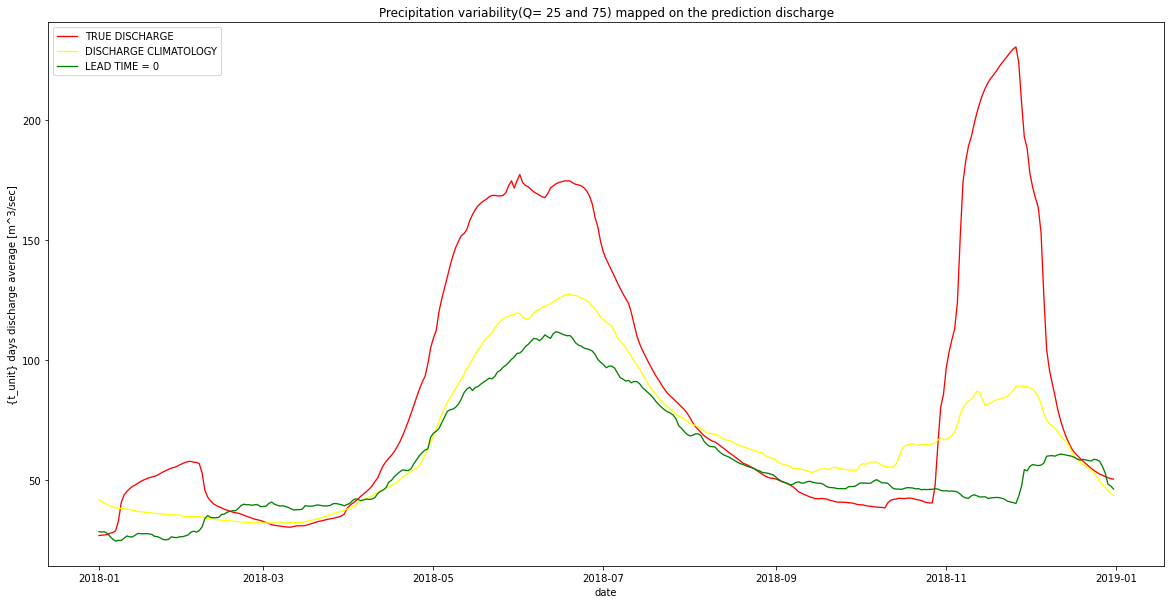

In [18]:
plot_prediction(predictions,t_unit)

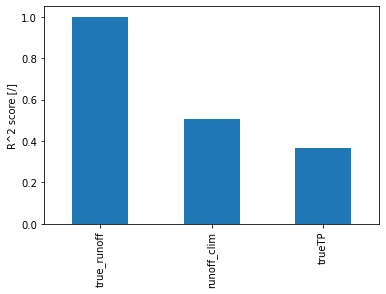

In [19]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [13]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits)

In [14]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


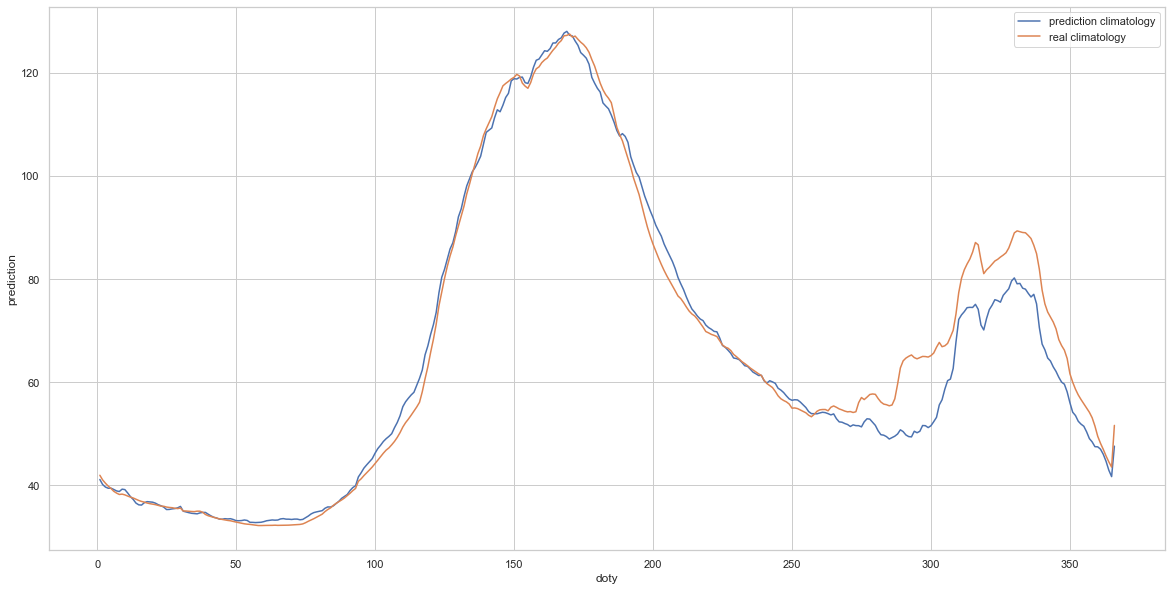

In [15]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

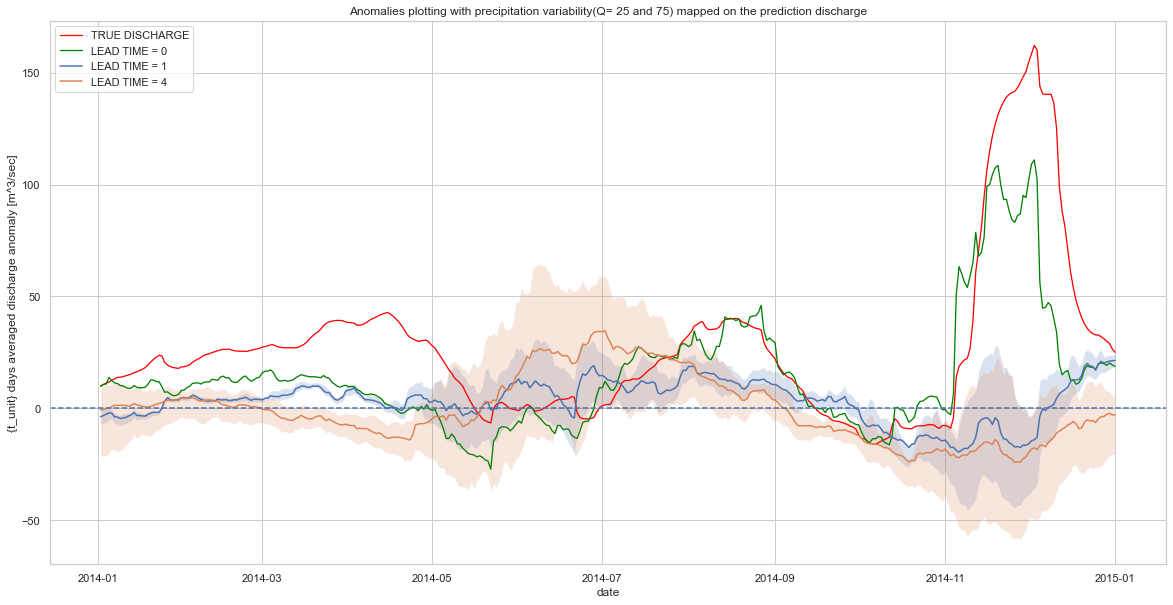

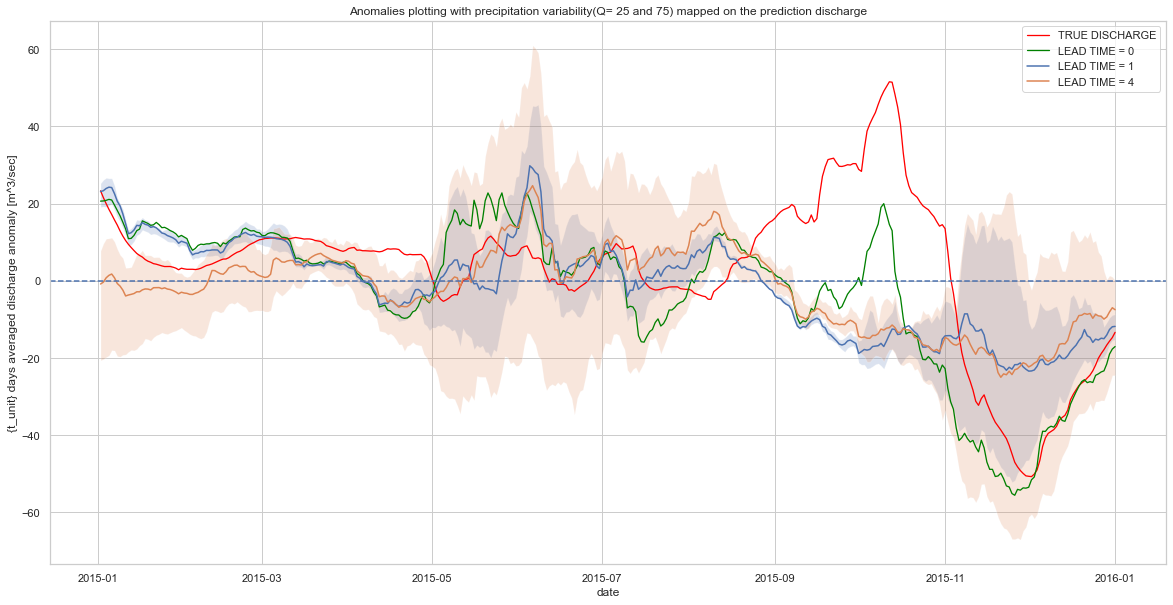

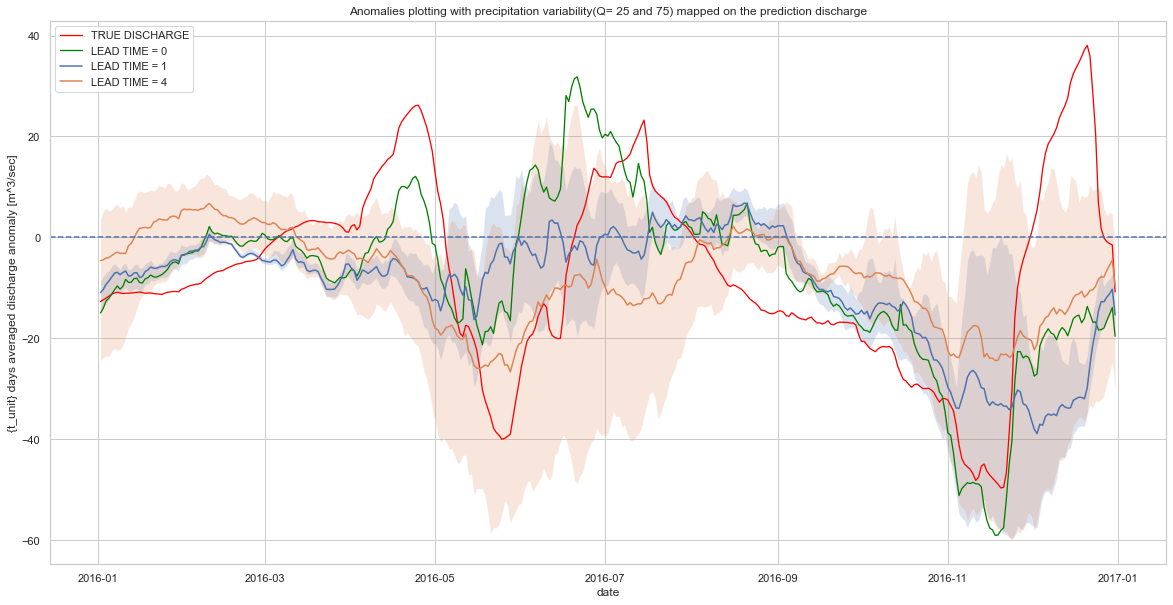

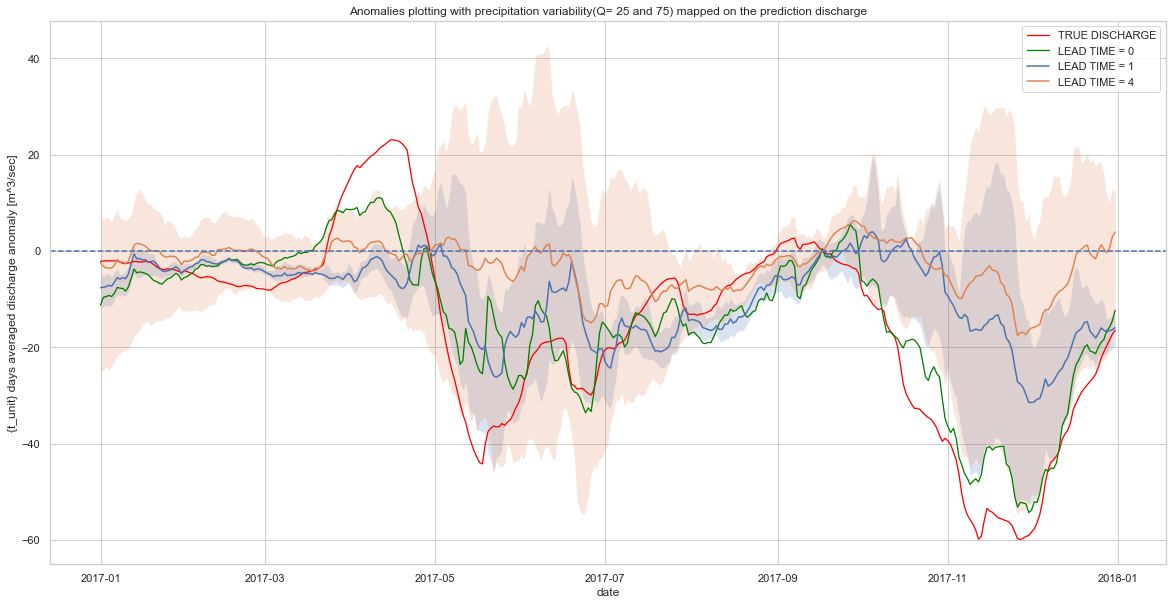

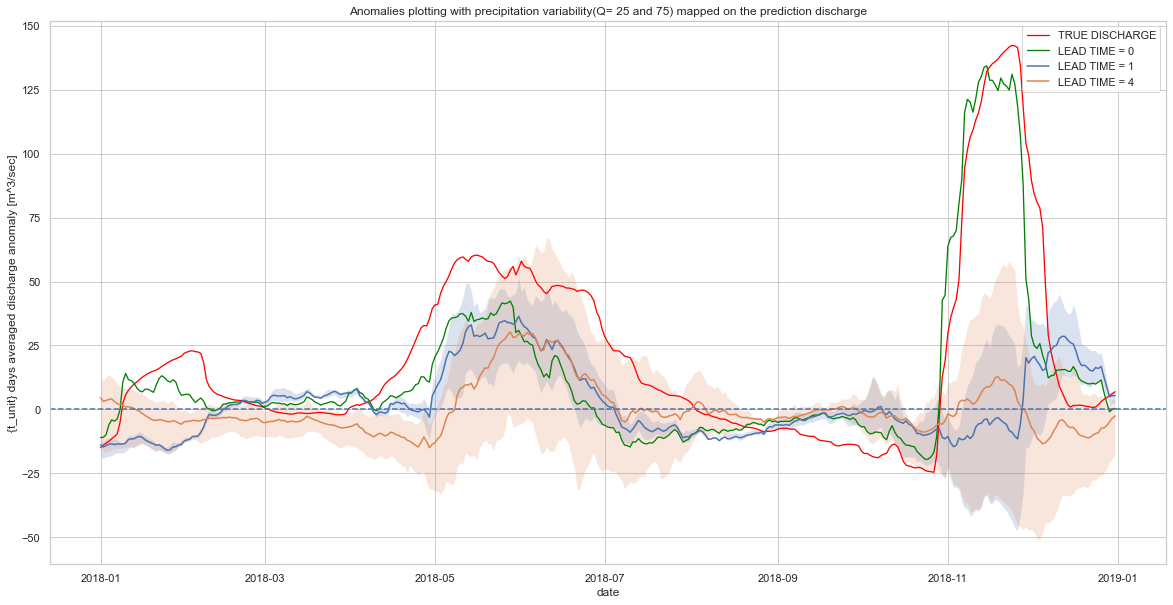

In [17]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split
plot_anomalies(a,t_unit)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C=0.046415888336127774
epsilon=0.1
n=36


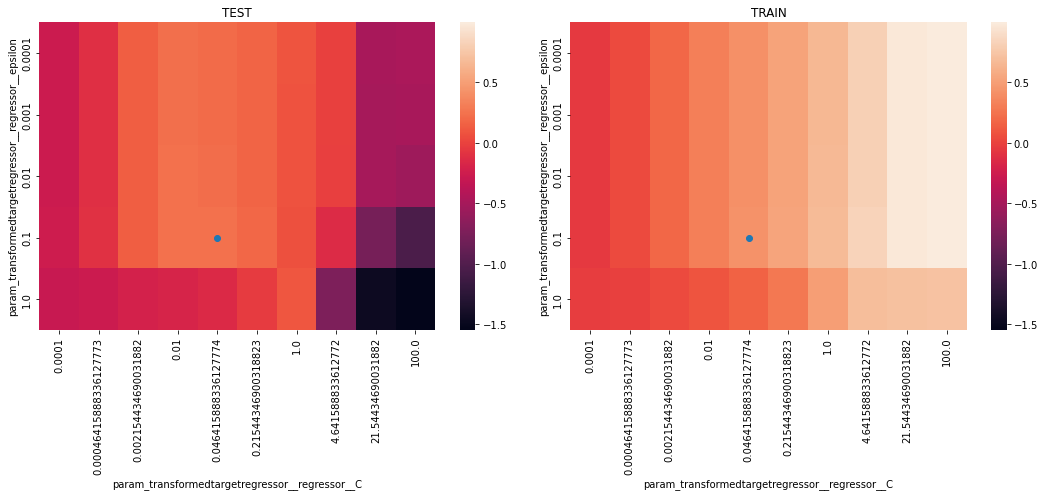

In [66]:
components_range2=[12*3]
C2,eps2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range2, t_range,t_unit, n_splits,test_size,lt)
print(f'C={C2}')
print(f'epsilon={eps2}')
print(f'n={n2}')

In [20]:
C2=0.5994842503189409
eps2=0.01
n2=36

C2  =0.5994842503189409
eps2=10e-06
n2  =36

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [67]:
radius_for_ensemble = 1
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

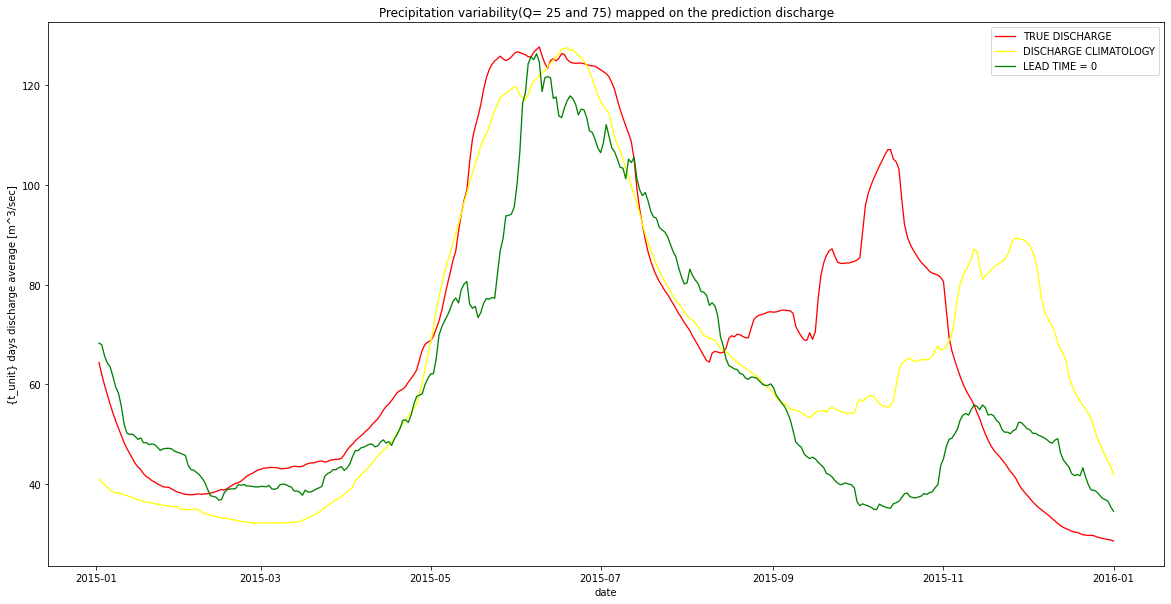

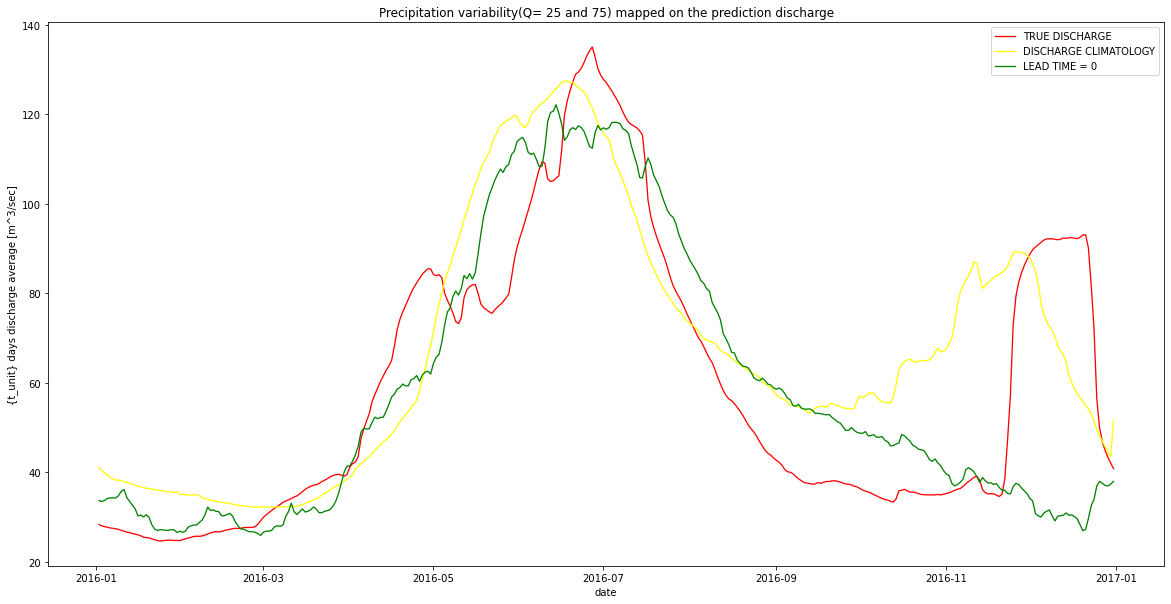

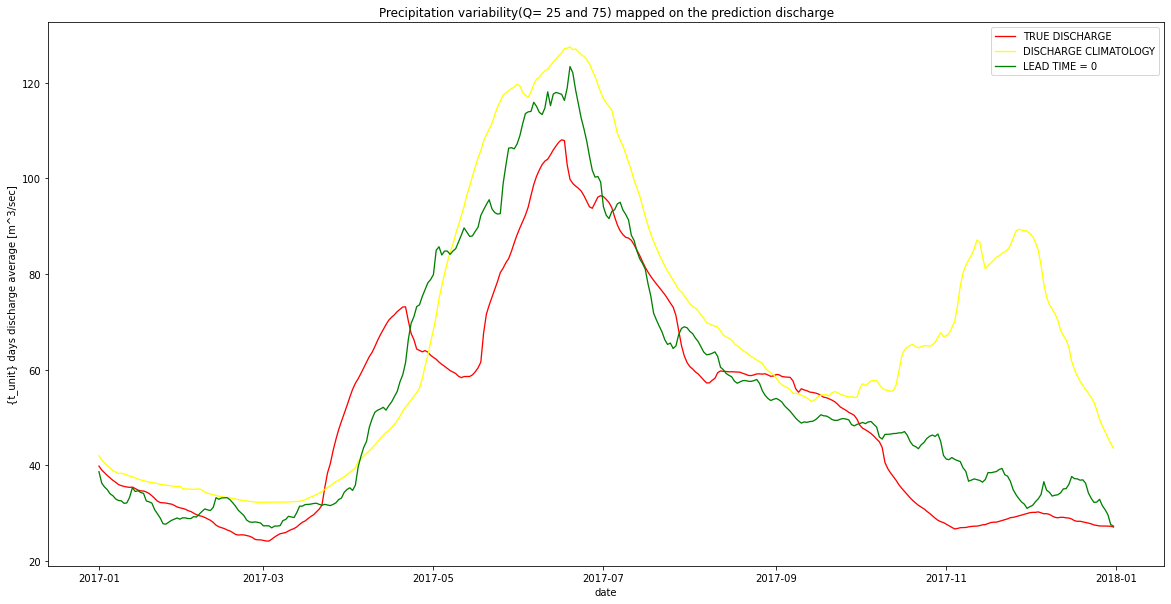

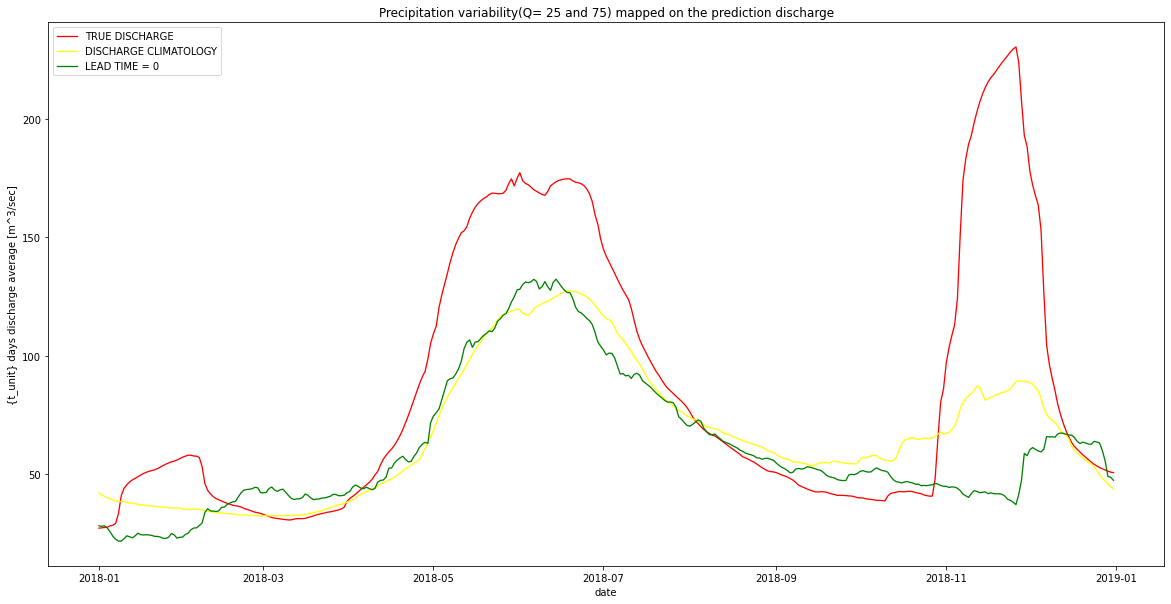

In [68]:
plot_prediction(predictions2,t_unit)

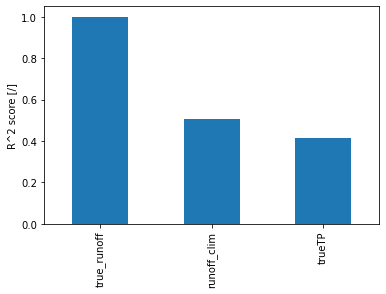

In [69]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits)
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


In [27]:
climatologies2=climatologies

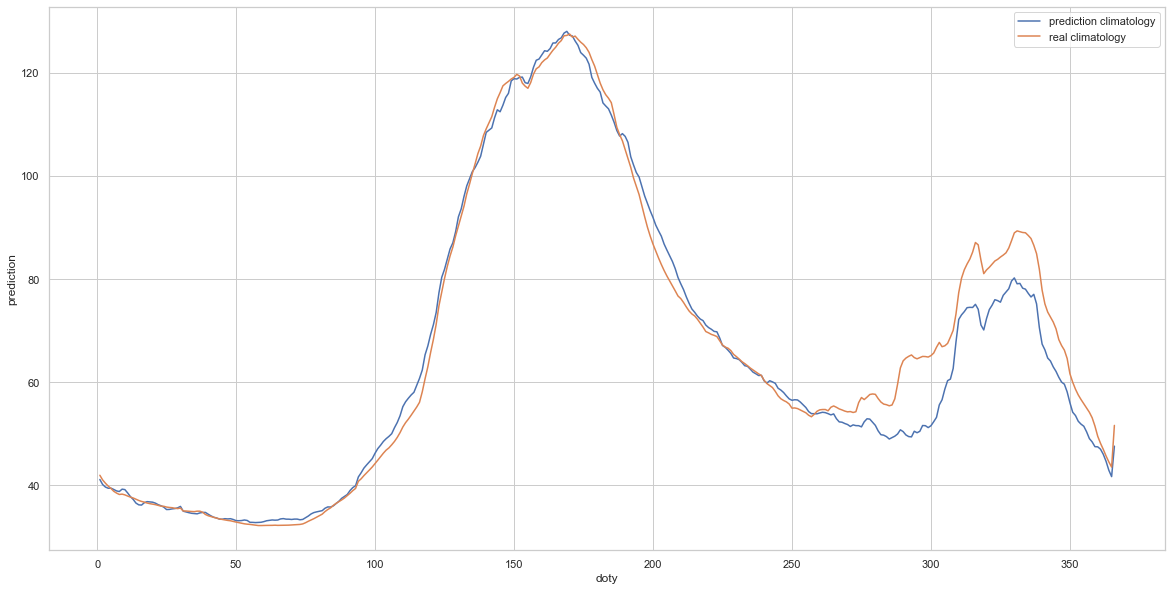

In [28]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

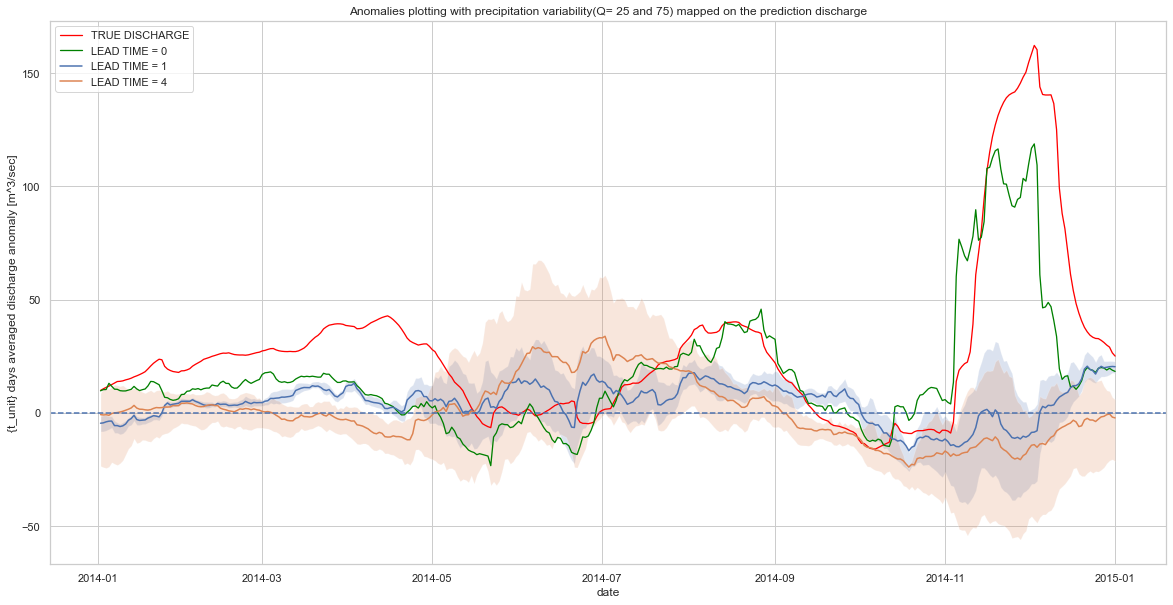

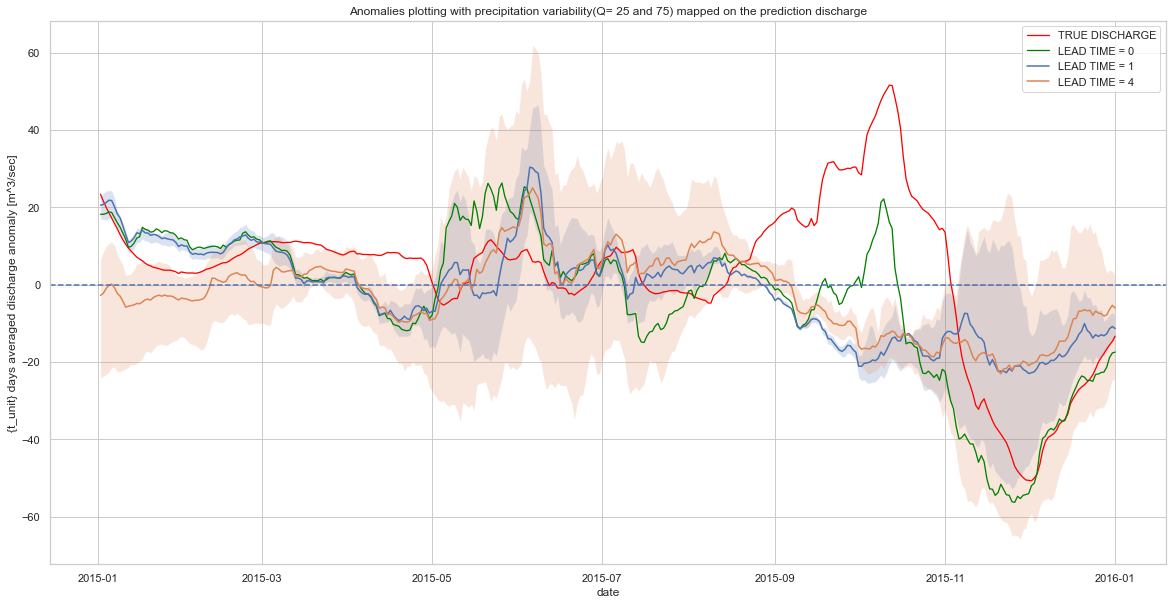

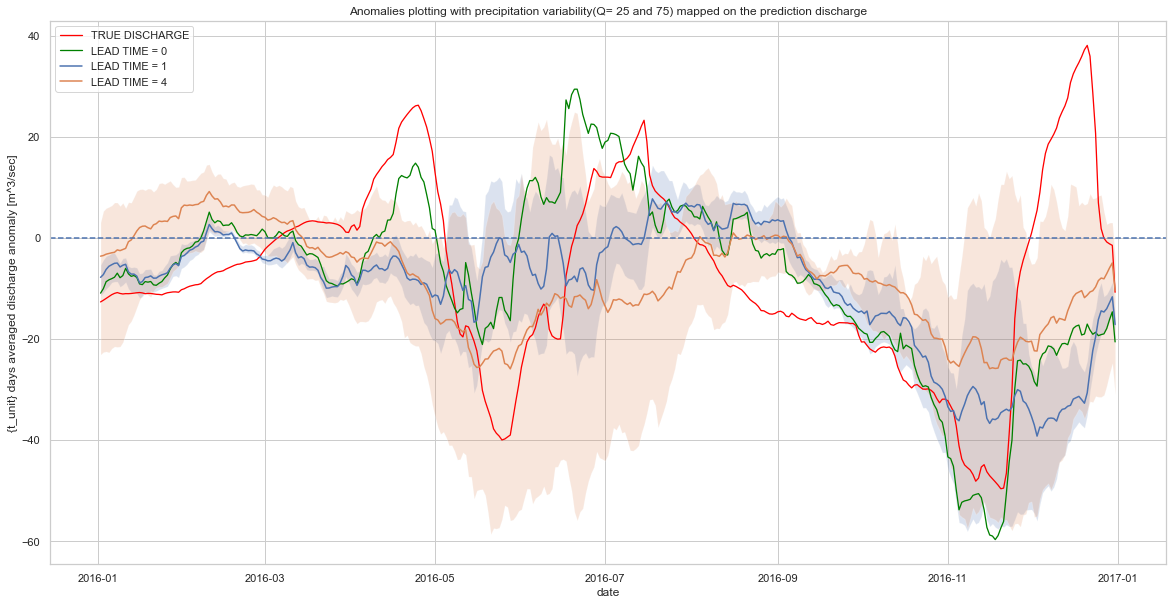

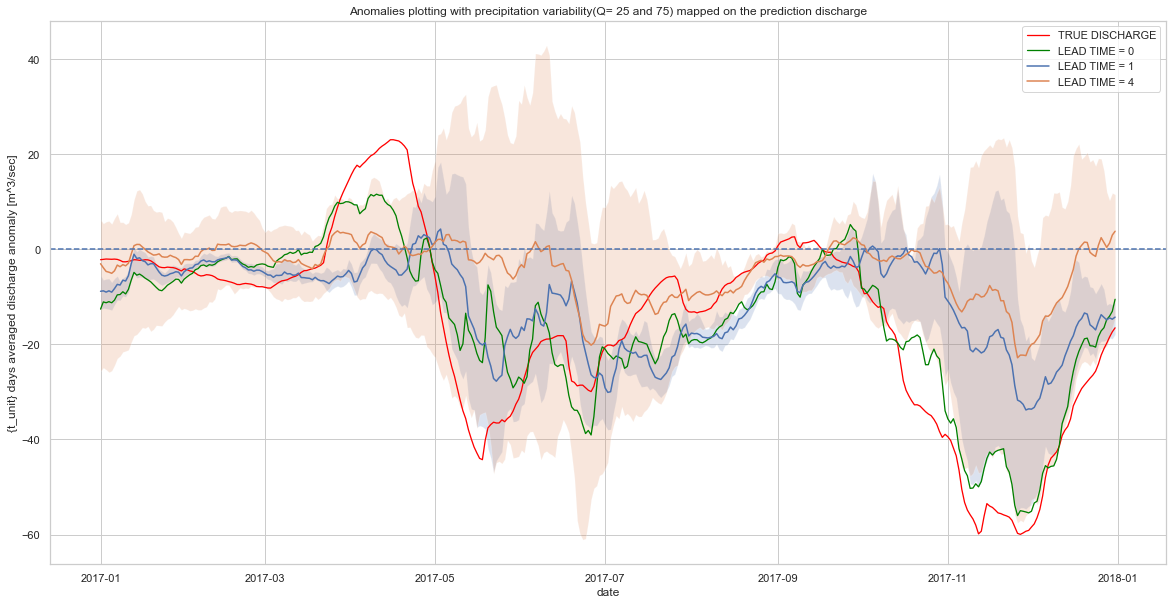

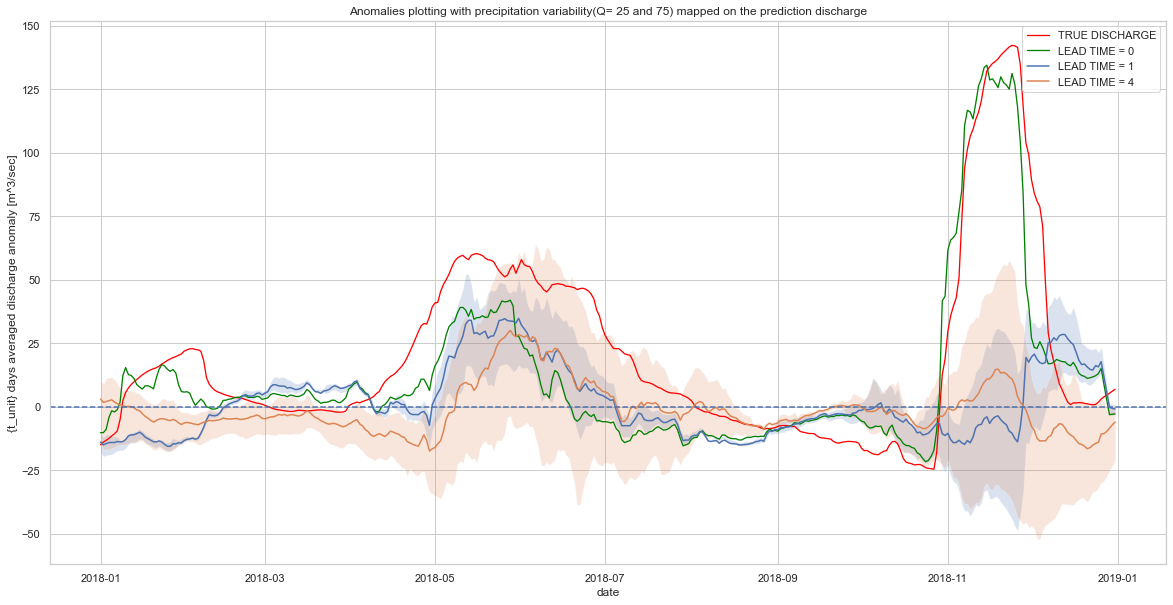

In [30]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split
plot_anomalies(a2,t_unit)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C3=0.01
eps3=0.1


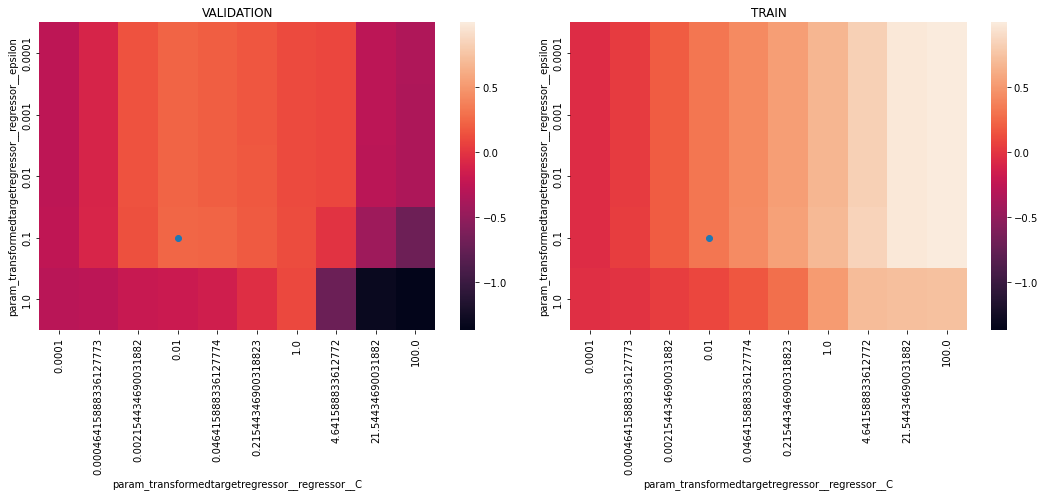

In [73]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [31]:
C3=0.5994842503189409
eps3=7.742636826811277e-06

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [74]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

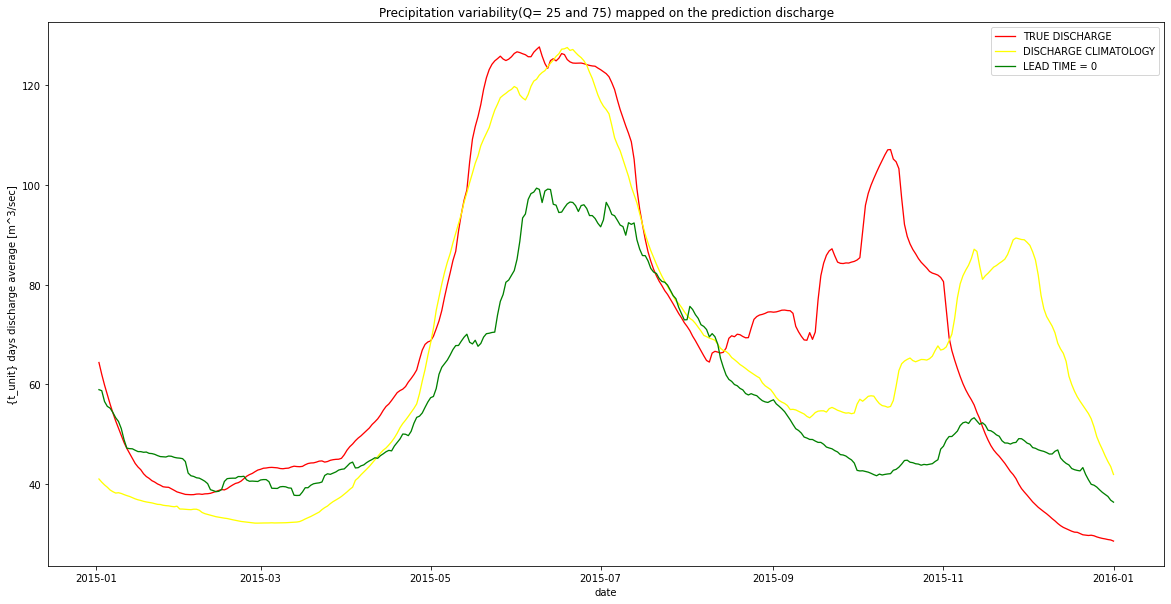

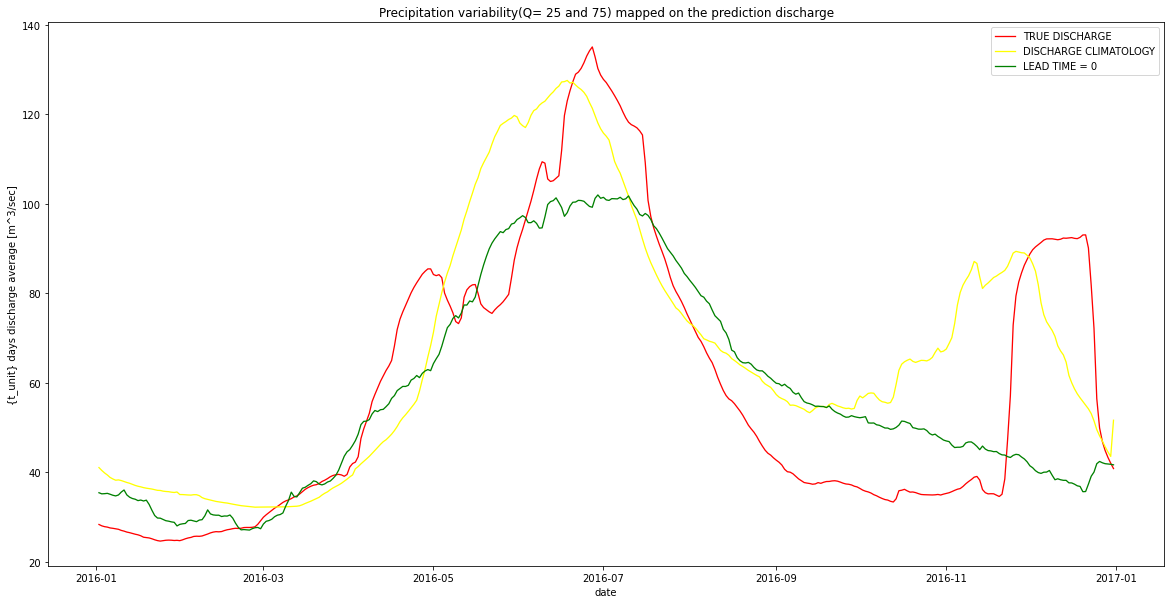

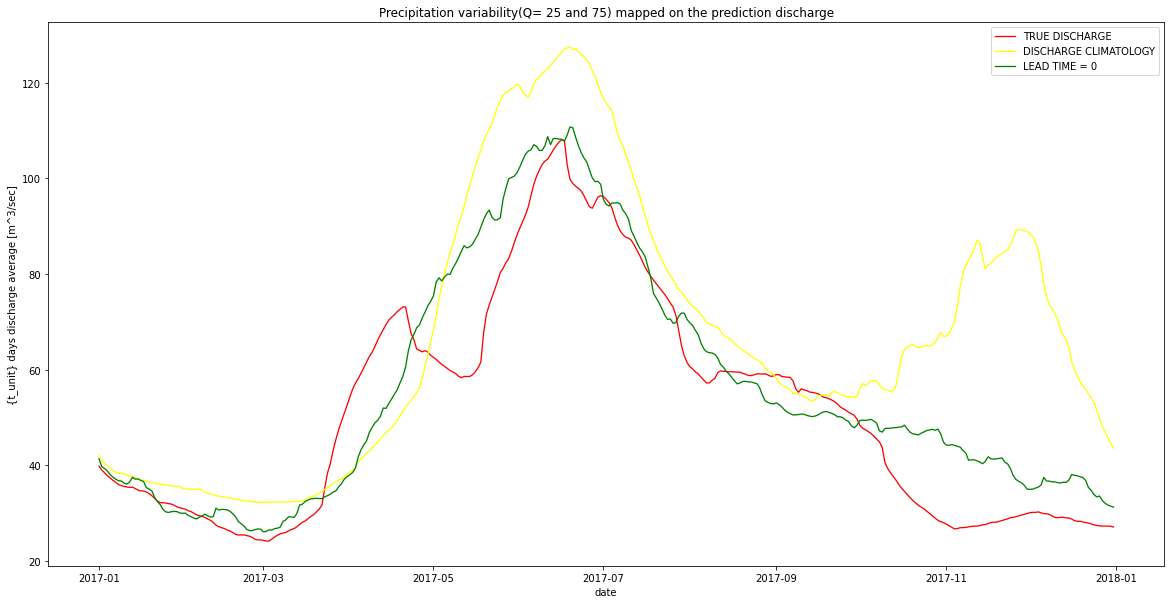

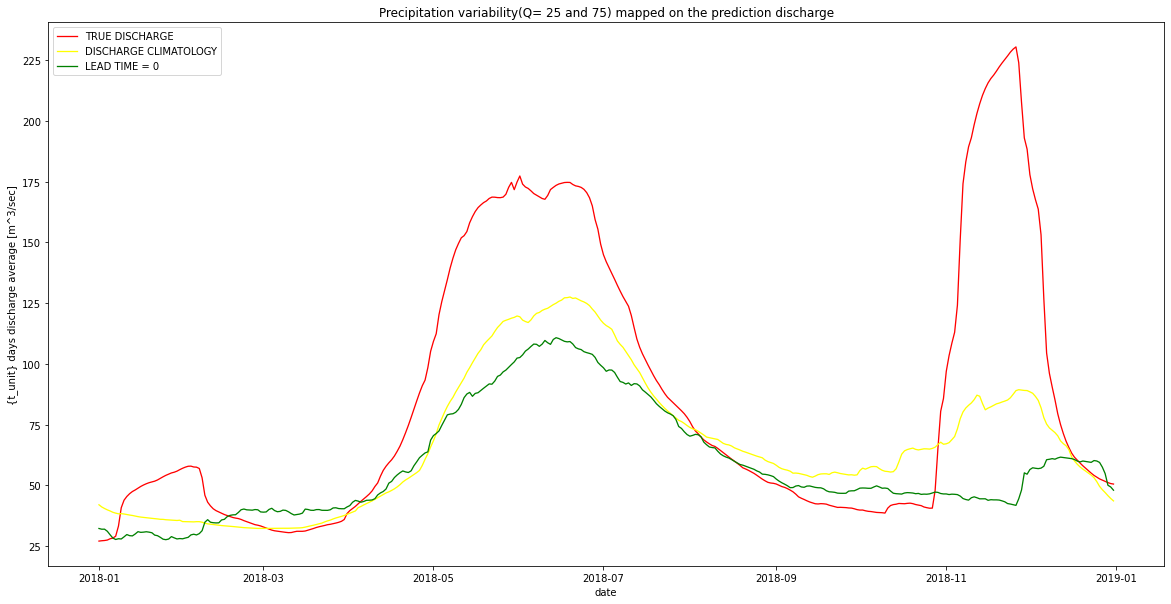

In [75]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3,t_unit)

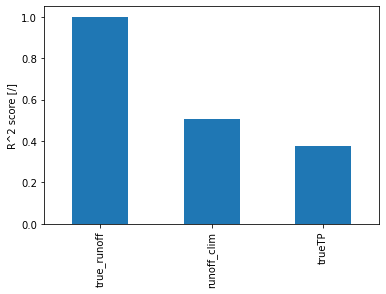

In [76]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3, 12, n_splits)

climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


In [38]:
climatologies3=climatologies

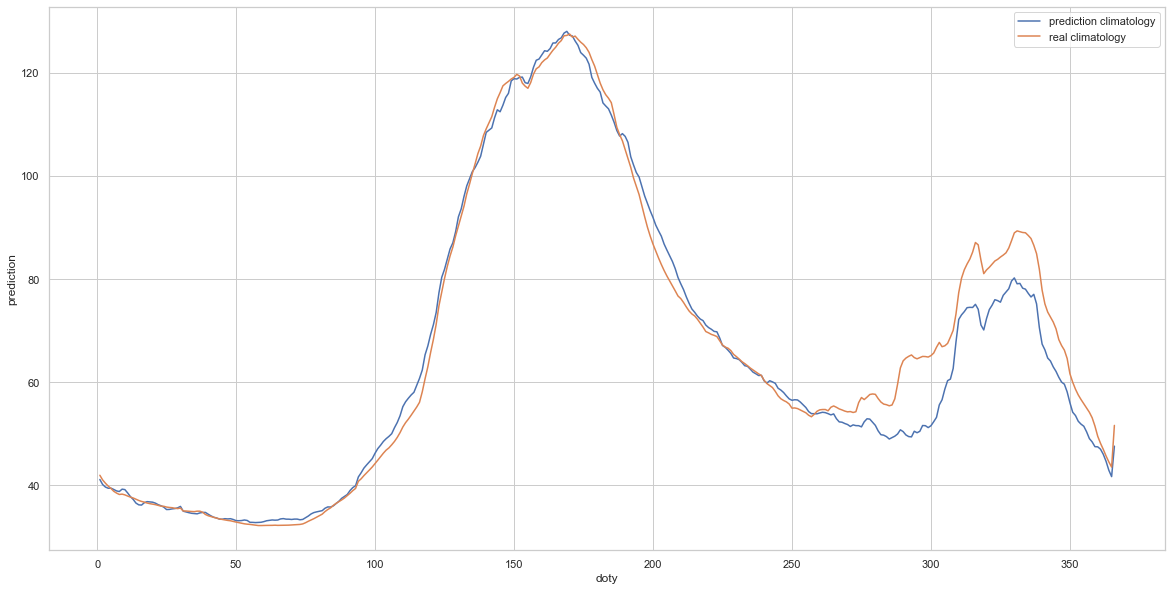

In [39]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

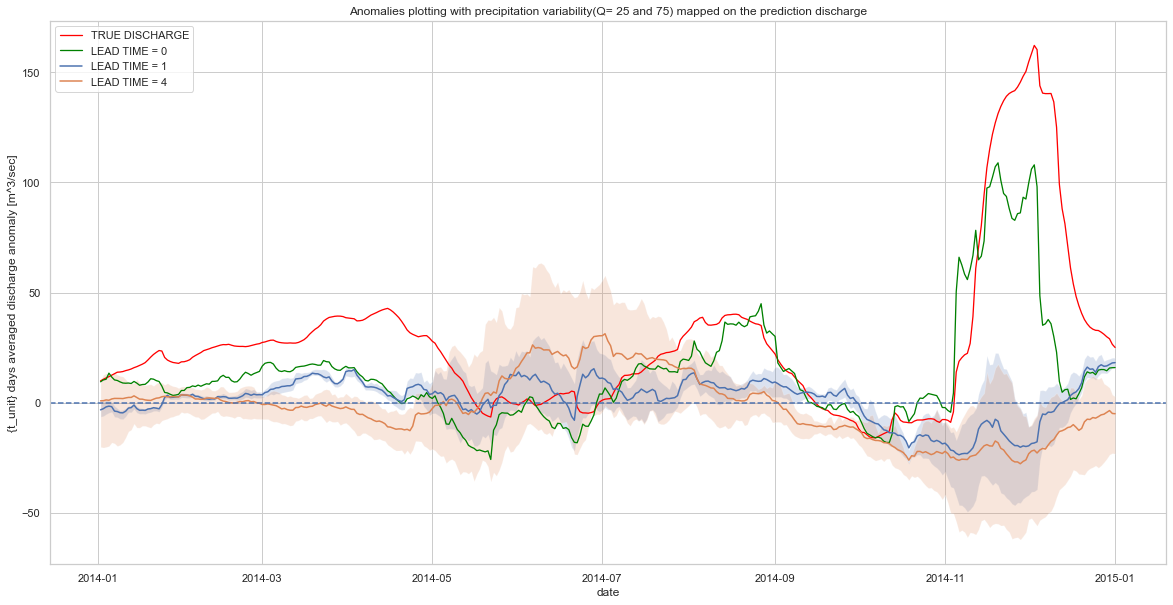

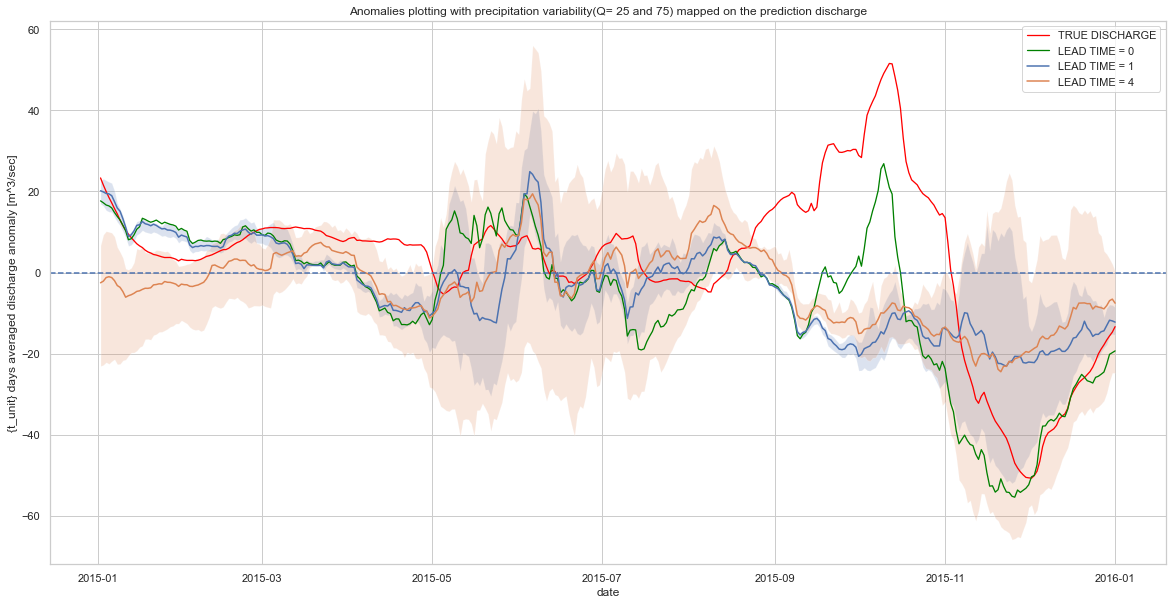

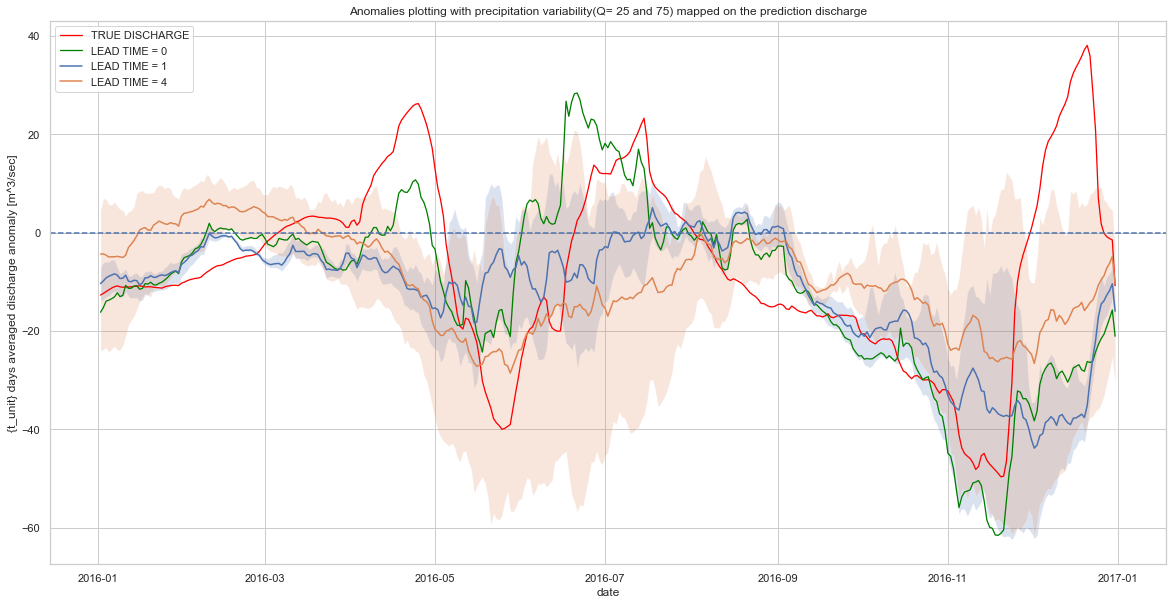

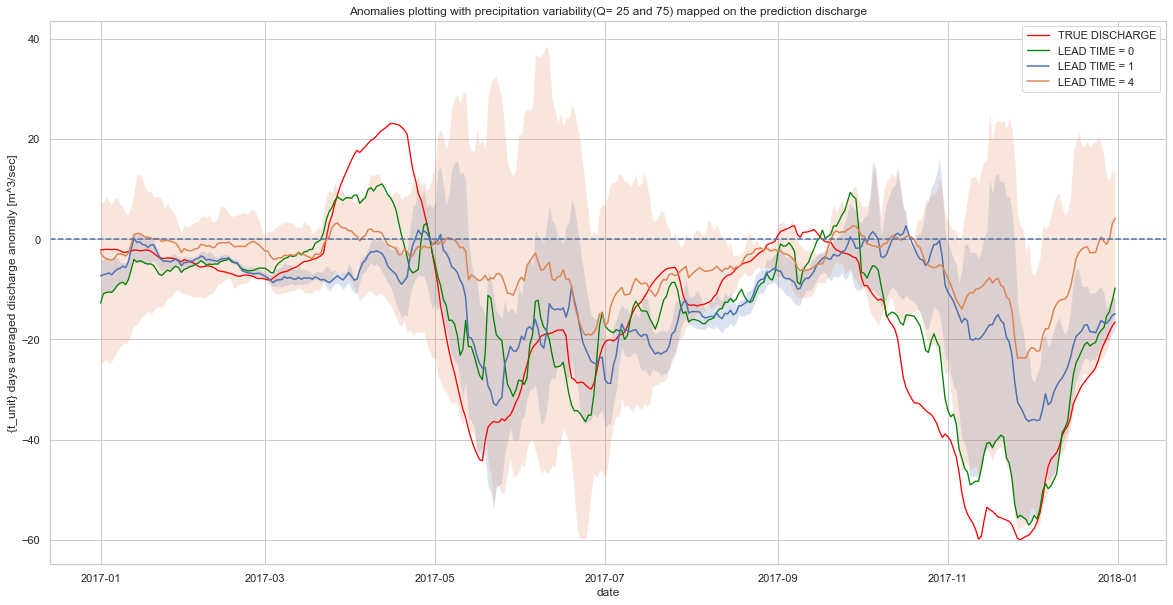

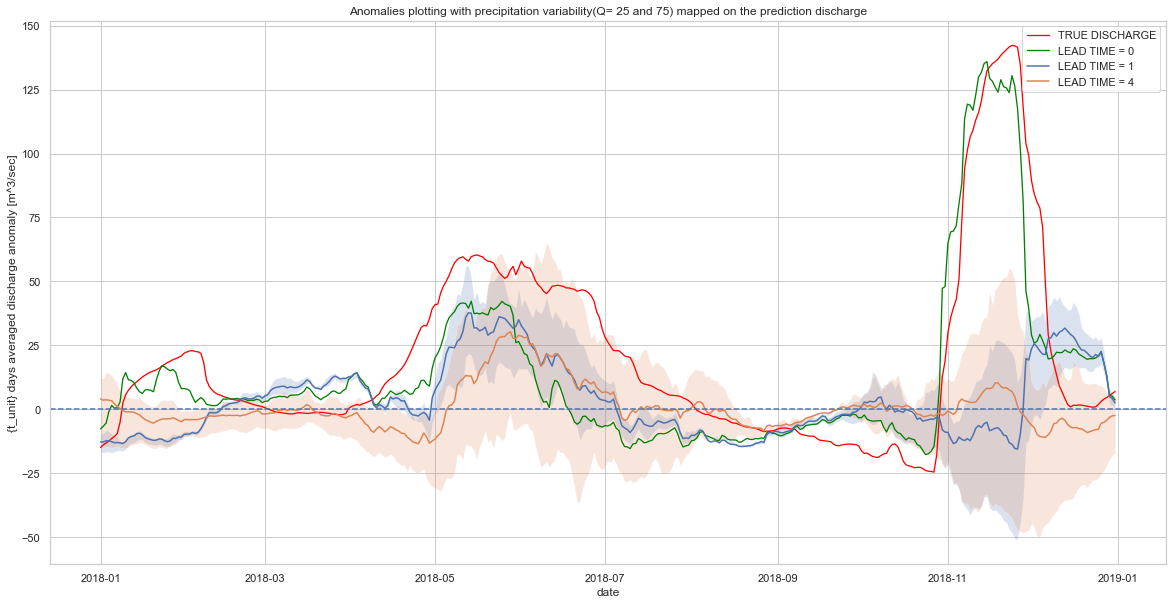

In [40]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3,t_unit)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C4=0.01
eps4=0.1


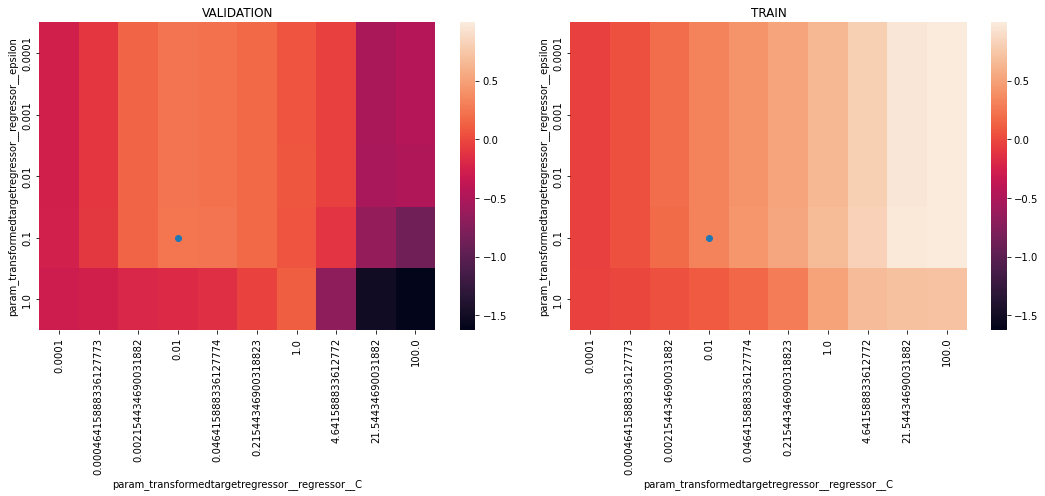

In [77]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C4={C4}')
print(f'eps4={eps4}')

In [41]:
C4=0.21544346900318834
eps4=0.01

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [78]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

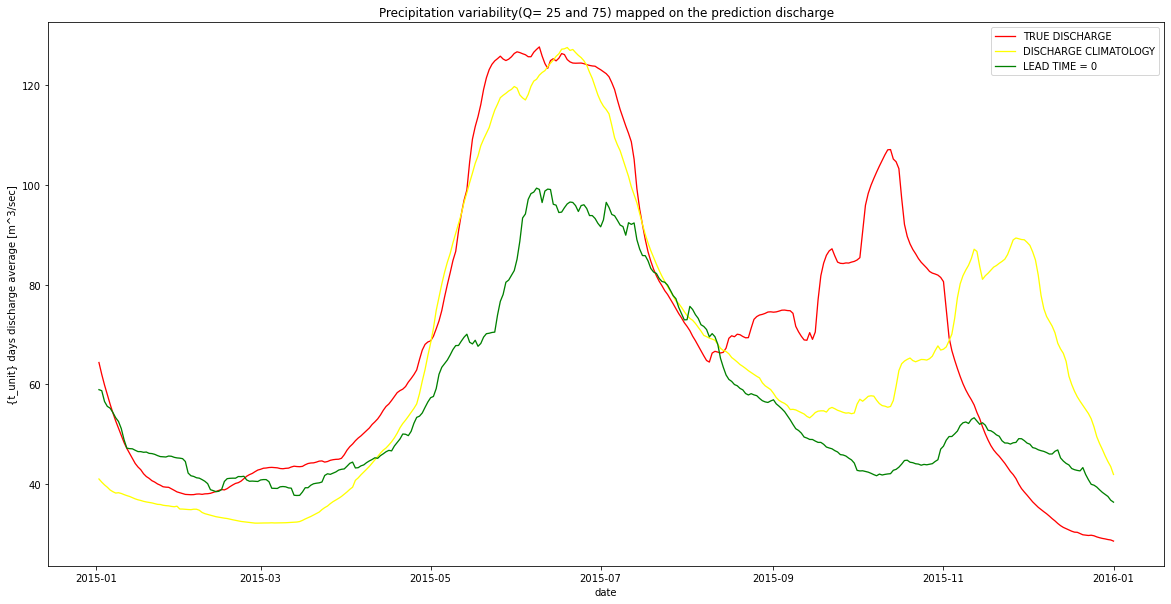

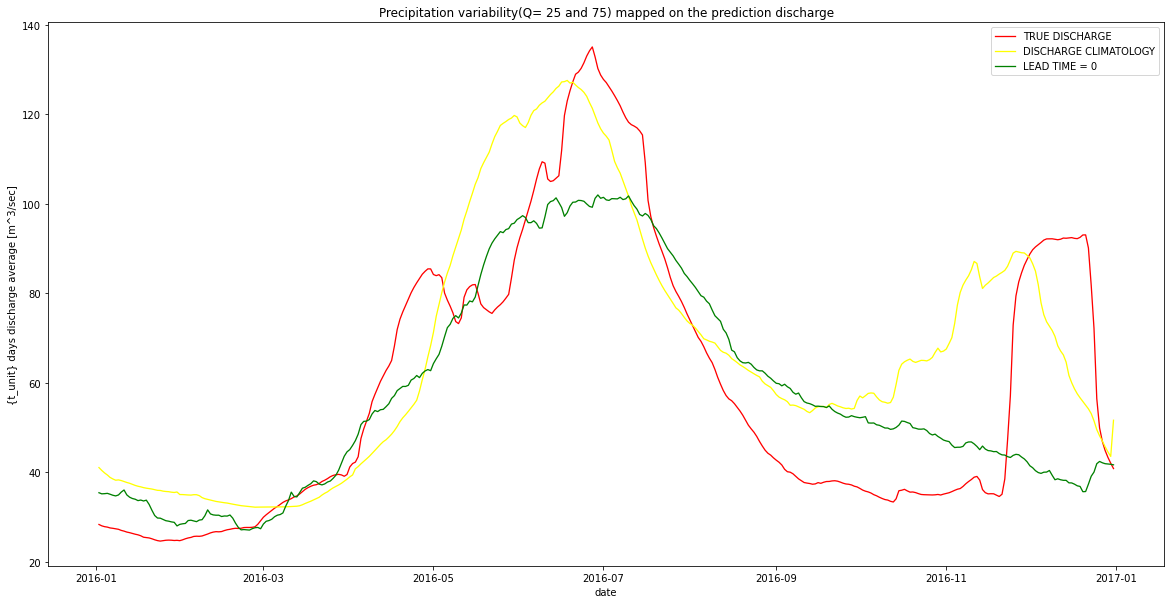

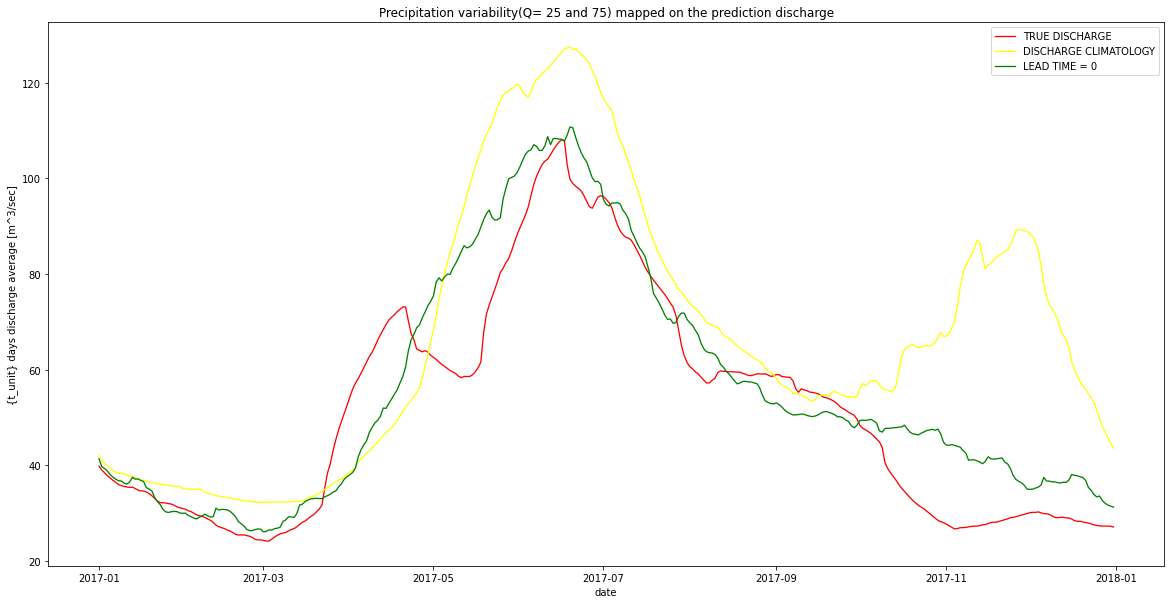

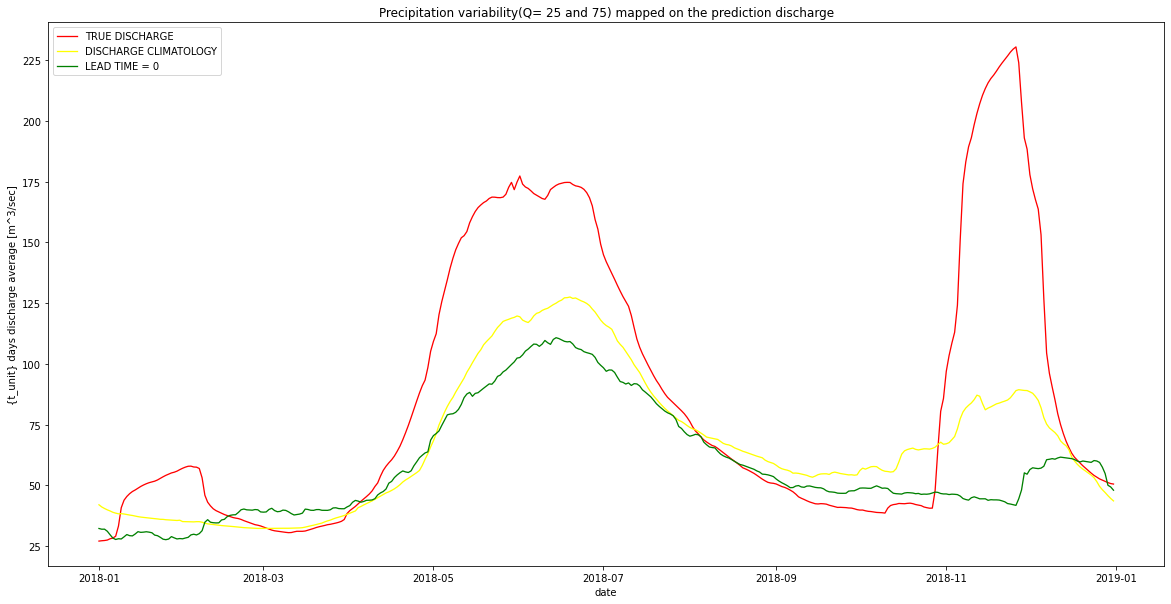

In [79]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4,t_unit)

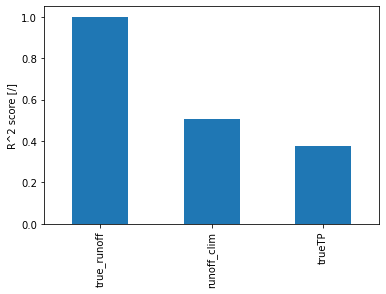

In [80]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4, 12,t_unit, n_splits)

climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


In [46]:
climatologies4=climatologies

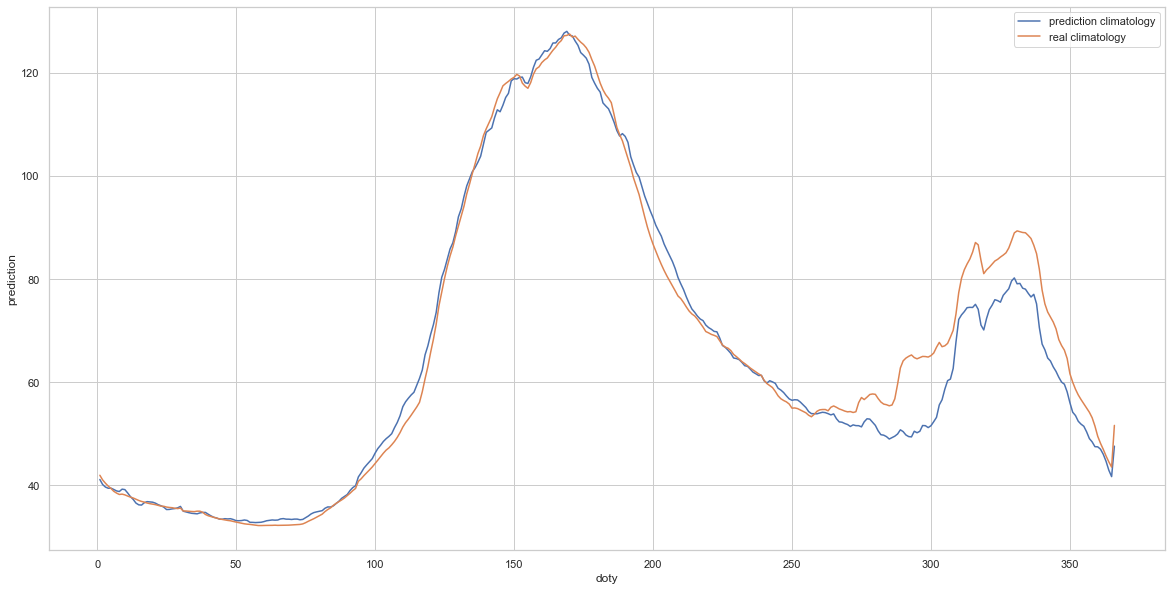

In [47]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

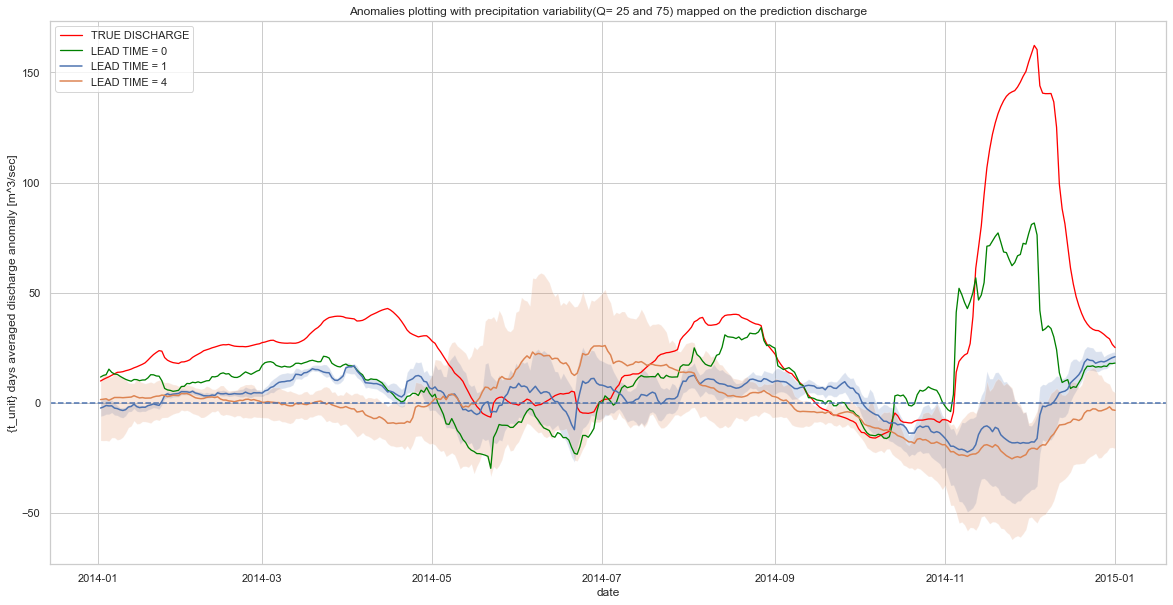

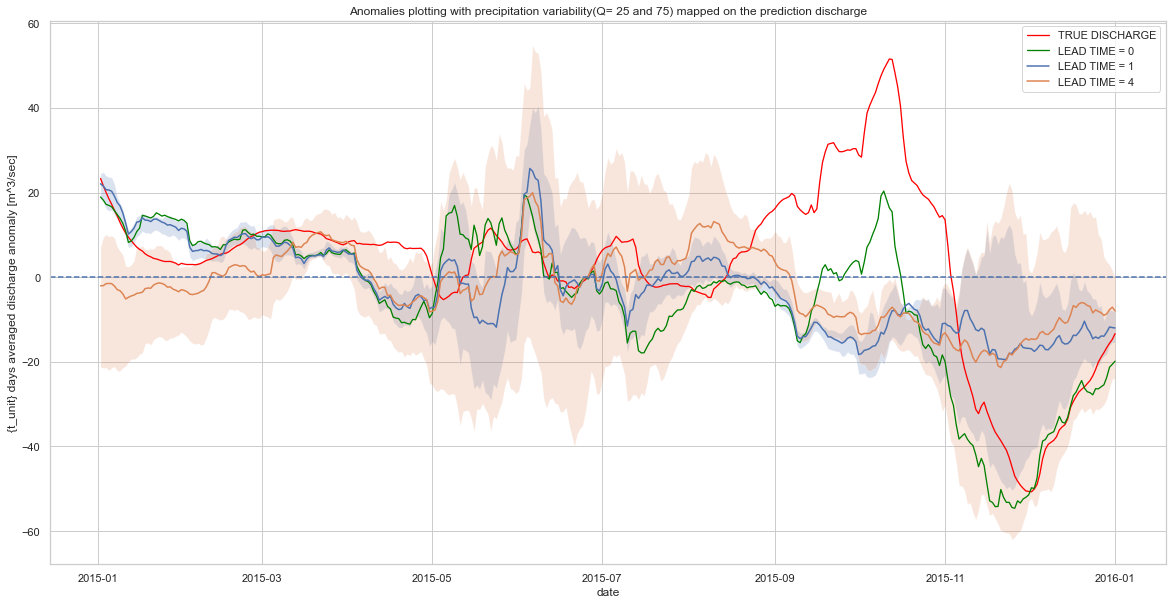

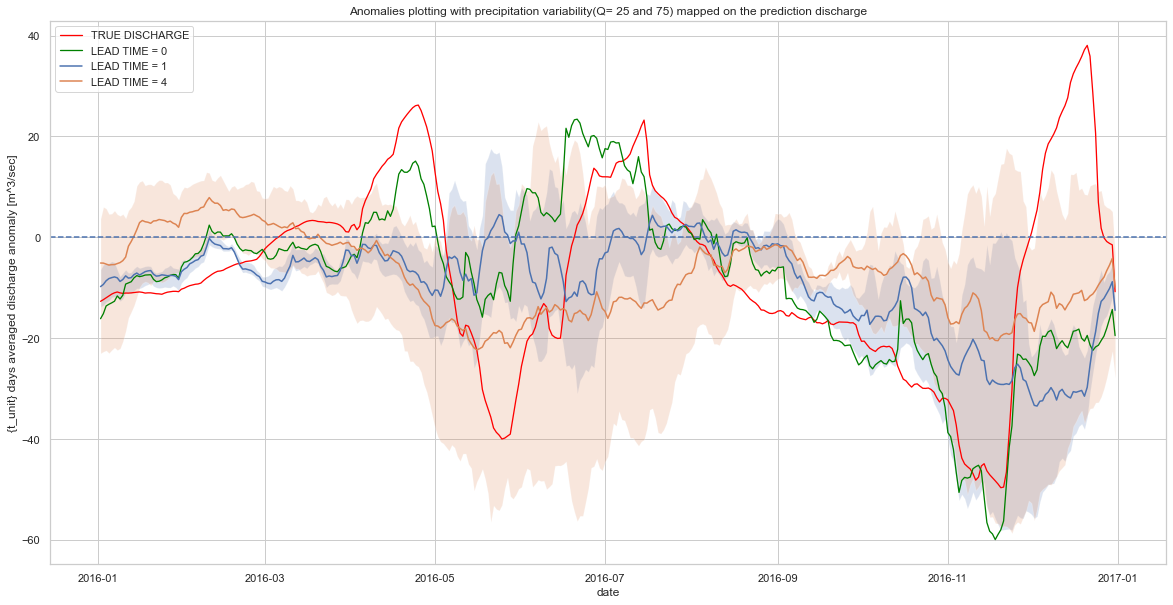

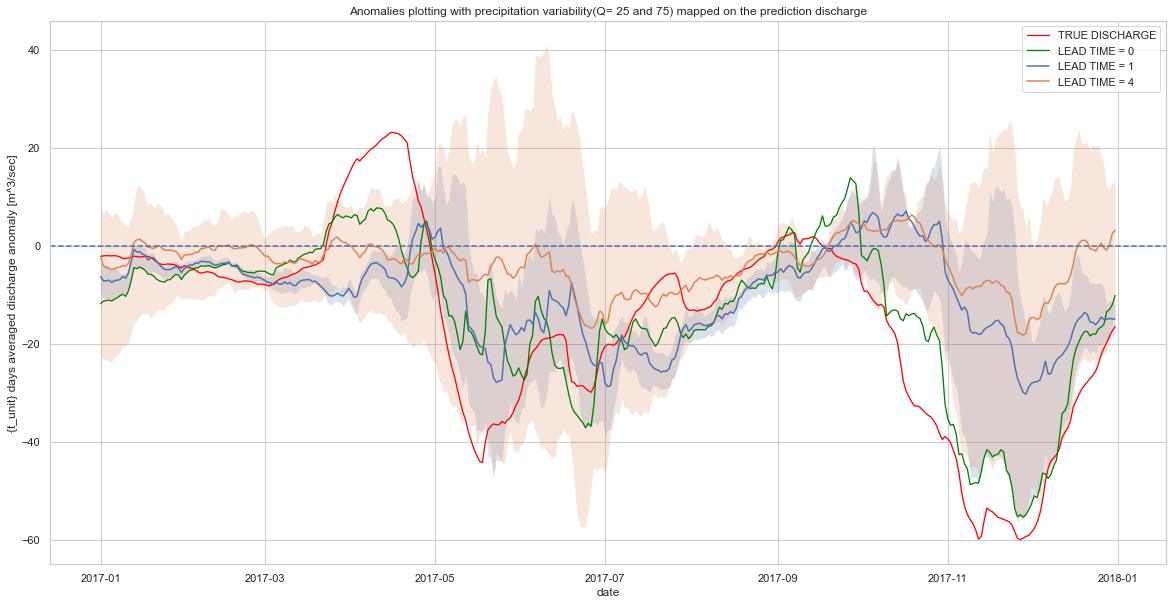

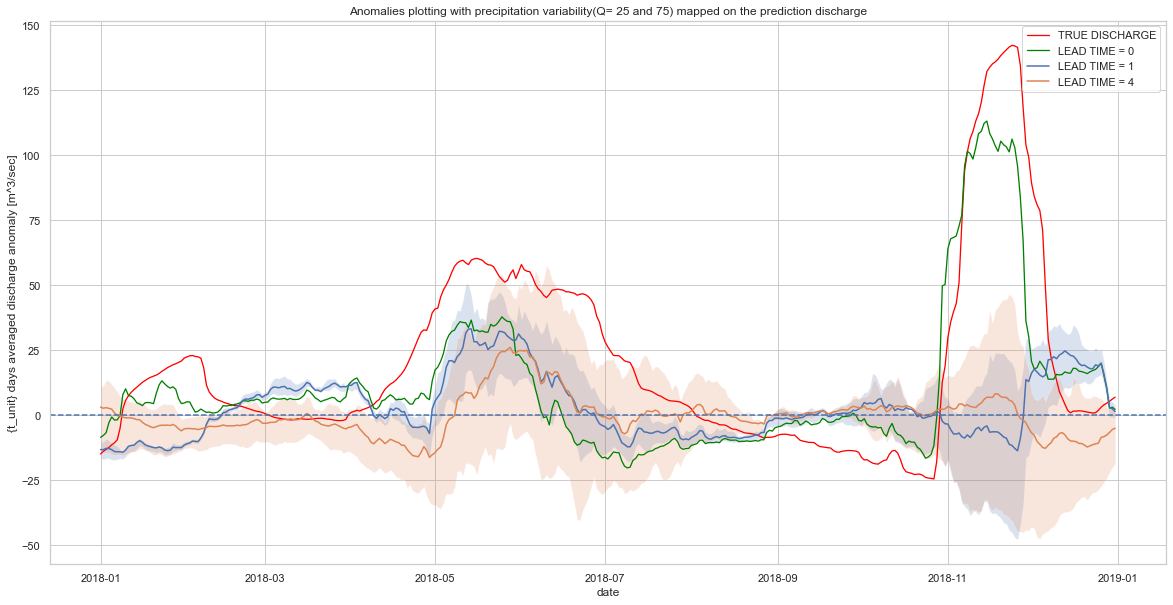

In [48]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4,t_unit)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

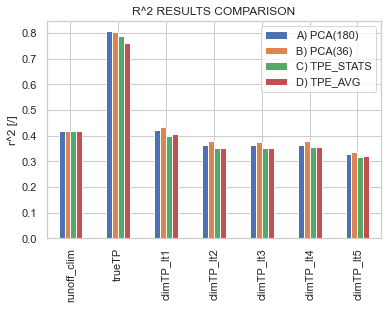

In [52]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_STATS,r2_TPE],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

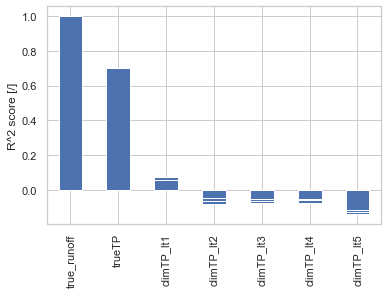

In [50]:
r2_TPE_an = evaluate_prediction(a4)
r2_STATS_an= evaluate_prediction(a3)
r2_PCA36_an = evaluate_prediction(a2)
r2_PCA180_an = evaluate_prediction(a)

Text(0, 0.5, 'r^2 [/]')

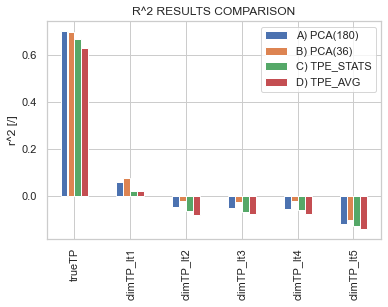

In [51]:
results = pd.concat([r2_PCA180_an,r2_PCA36_an,r2_STATS_an,r2_TPE_an],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C4=0.01
eps4=0.1


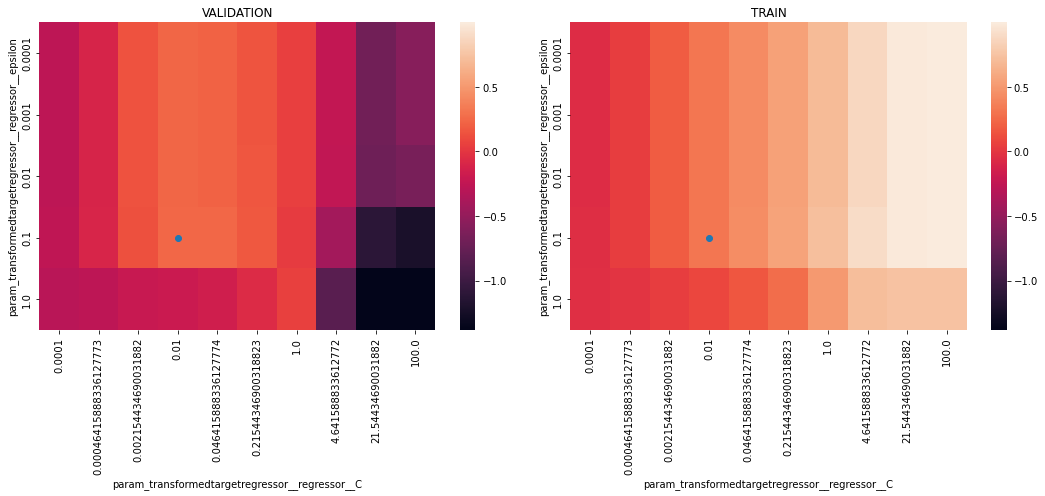

In [82]:
C5, eps5 = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C4={C5}')
print(f'eps4={eps5}')

In [84]:
###### radius_for_ensemble = 1
predictions5 = nested_CV_SVR_predict(daily_input_stat, C5, eps5, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

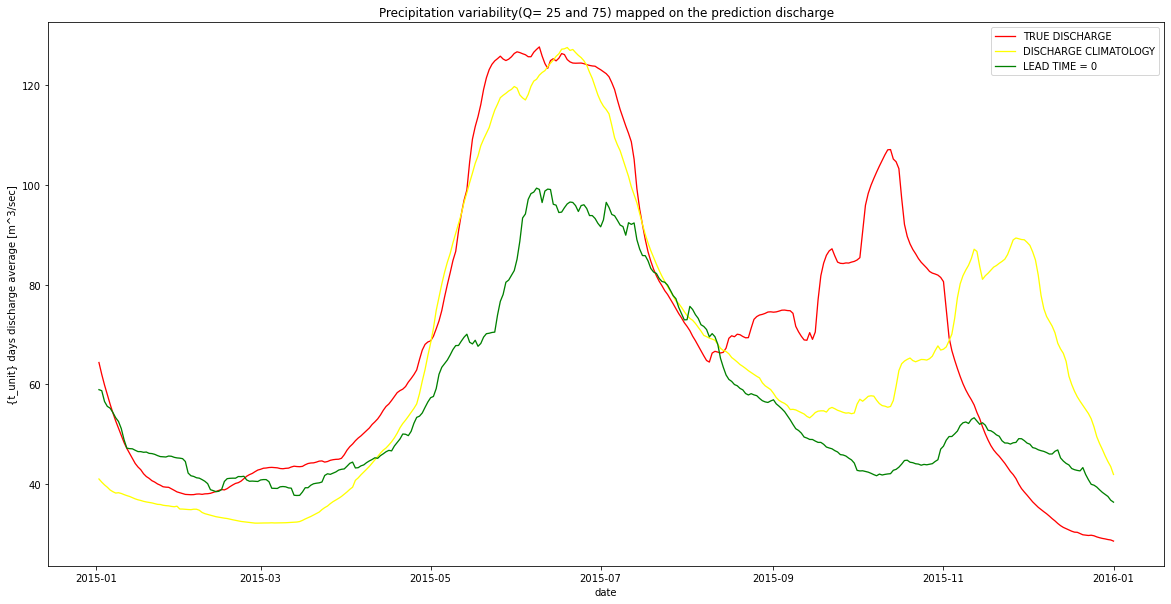

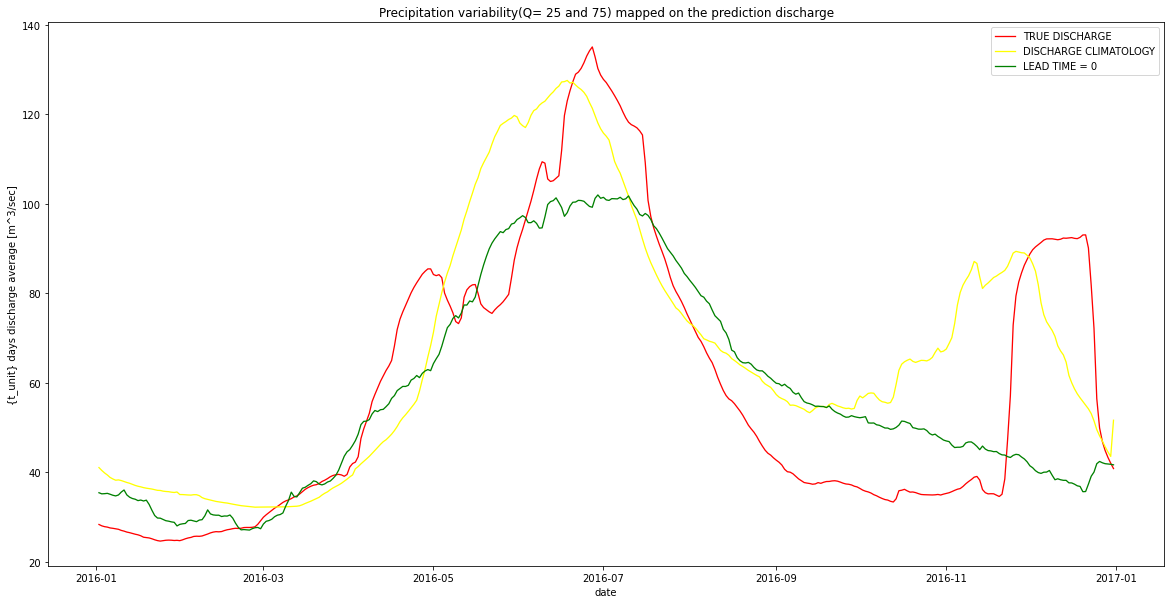

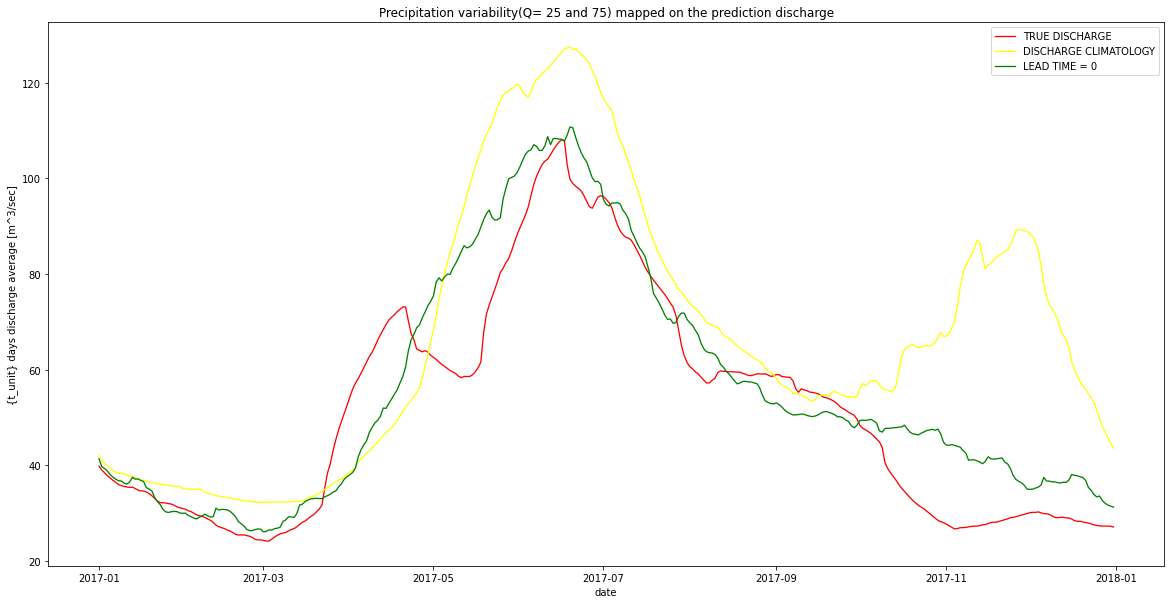

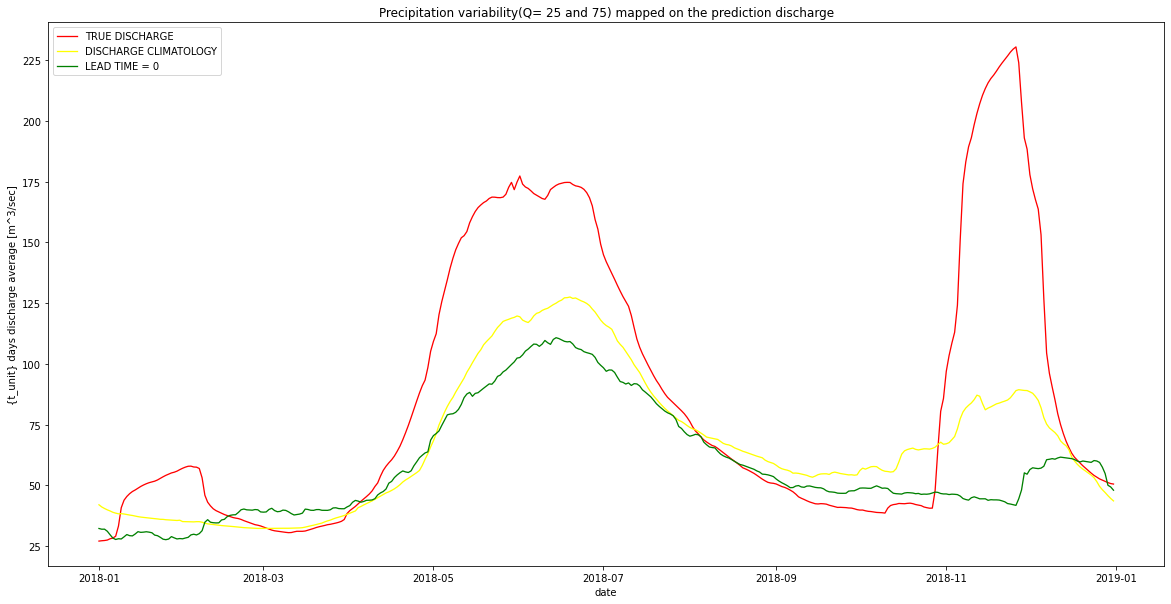

In [85]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions5,t_unit)

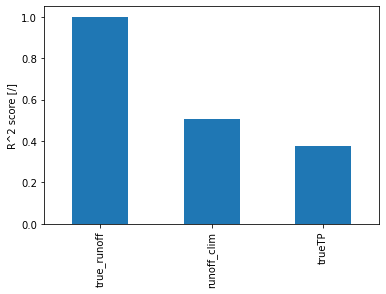

In [87]:
r2_TPE = evaluate_prediction(predictions5)